# <font color = '#e64626'><center>QBUS6810 Group Assignment</center></font>
### <center>Group X: *list student IDs here*</center>

# Table of Contents

1. [Data Processing](#data_processing)
2. [Exploratory Data Analysis](#eda)
<br> 2.1 [Response Variable](#response)
<br> 2.2 [Textual Variable](#text)
<br> 2.3 [Location Variable](#location)
<br> 2.4 [Other Numerical Variable](#numerical)
<br> 2.5 [Other Categorical Variable](#categorical)
3. [Feature Engineering](#feature_engineering)
4. [Methodology](#methodology)
<br> 4.1 [Model 1: Elastic Net](#model_1)
<br> 4.2 [Model 2: Decision Tree](#model_2)
<br> 4.3 [Model 3: Xgboost](#model_3)
5. [Appendix-Other Models We Tried](#appendix)

In [1]:
import numpy as np
import pandas as pd
pd.set_option('mode.use_inf_as_na', True)
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords
from nltk.stem.porter import PorterStemmer
from nltk import FreqDist
import ast
import re
from sklearn.metrics.pairwise import haversine_distances
from math import radians
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from collections import Counter
from bs4 import BeautifulSoup

C:\Users\Cayde Li\AppData\Local\Temp\ipykernel_20800\845185415.py:3: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('mode.use_inf_as_na', True)


In [2]:
# 统一图表格式 from jupyter_scaffold
rc = {"xtick.labelsize": 12, "ytick.labelsize": 12, "axes.labelsize": 15, 
      "axes.titlesize": 15, "legend.fontsize": 12}
sns.set_context("notebook", rc=rc)  

## <font color = '#e64626'><a id='data_processing'>1. Data Processing</a></font>

In [3]:
#Read csv file
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
response = 'price'
y_train = data_train[response]
print(data_train.info())
print(data_test.info())
data_train.head(12)
# 可以看出在train set里只有beds有缺失值，test set无缺失值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           12500 non-null  int64  
 1   price                        12500 non-null  int64  
 2   description                  12500 non-null  object 
 3   neighborhood_overview        12500 non-null  object 
 4   host_acceptance_rate         12500 non-null  float64
 5   neighbourhood                12500 non-null  object 
 6   latitude                     12500 non-null  float64
 7   longitude                    12500 non-null  float64
 8   property_type                12500 non-null  object 
 9   room_type                    12500 non-null  object 
 10  accommodates                 12500 non-null  int64  
 11  bedrooms                     12500 non-null  float64
 12  beds                         12498 non-null  float64
 13  amenities       

id  price                                        description  \
0   2500    260  Secluded, self-contained studio apartment just...   
1   2501    264  Located in a heritage-listed apartment block, ...   
2   2502    130  Looking for a peaceful place in paradise? Heal...   
3   2503    171  Melbourne City Retreat. Best Location in the H...   
4   2504    194  This relaxing, spacious, beach side 1 bedroom ...   
5   2505     51  ✔ Cosy little guest house with everything you ...   
6   2506    130  This stylish studio apartment comes with rever...   
7   2507    136  Boutique 1 bedroom apartment, large bathroom a...   
8   2508    120  Quiet self contained room in upmarket Mosman w...   
9   2509    189  A newly renovated deluxe studio with fantastic...   
10  2510    117  Gardens, walks, Cafes and weekend markets.<br ...   
11  2511    229  https://www.airbnb.com.au/rooms/32406846?s=51<...   

                                neighborhood_overview  host_acceptance_rate  \
0   Friendly neighbourhood with easy access to Man...                  0.67   
1   This impressive property on the city fringe is...                  0.98   
2   Located a short drive to Nana Glen village, we...                  0.88   
3   Melbourne Central · Victoria Market · Emporium...                  1.00   
4   The property is located in the hip heart of Bo...                  0.99   
5   Doncaster is a lovely, leafy suburb that hosts...                  1.00   
6   Richmond is located just 3 kilometres from Mel...                  0.93   
7   Quiet street and close to Rainbow hotel and Na...                  0.99   
8   Mosman is an upmarket area situated between mi...                  1.00   
9   Potts Point is a dynamic suburb located close ...                  1.00   
10  Lovely open inviting Sydney people in this nei...                  0.99   
11  Skinners Shoot is the unique gem of a spot tha...                  1.00   

          neighbourhood   latitude   longitude                property_type  \
0                 Manly -33.793440  151.280990            Entire guesthouse   
1                 Yarra -37.798788  145.000433           Entire rental unit   
2         Coffs Harbour -30.154650  153.019150            Entire guesthouse   
3             Melbourne -37.807930  144.961110           Entire rental unit   
4              Waverley -33.890310  151.270760           Entire rental unit   
5            Manningham -37.781880  145.108410              Entire bungalow   
6                 Yarra -37.814560  144.991880           Entire rental unit   
7                 Yarra -37.800450  144.980380           Entire rental unit   
8                Mosman -33.822778  151.239731  Private room in guest suite   
9                Sydney -33.872740  151.221010           Entire rental unit   
10               Sydney -33.870220  151.224840           Entire rental unit   
11  BYRON SHIRE COUNCIL -28.665860  153.592470                         Tent   

          room_type  accommodates  bedrooms  beds  \
0   Entire home/apt             2       1.0   1.0   
1   Entire home/apt             2       1.0   3.0   
2   Entire home/apt             3       2.0   2.0   
3   Entire home/apt             6       2.0   4.0   
4   Entire home/apt             2       1.0   1.0   
5   Entire home/apt             2       1.0   1.0   
6   Entire home/apt             2       1.0   1.0   
7   Entire home/apt             2       1.0   1.0   
8      Private room             2       1.0   1.0   
9   Entire home/apt             2       1.0   1.0   
10  Entire home/apt             2       1.0   1.0   
11  Entire home/apt             2       1.0   1.0   

                                            amenities  minimum_nights  \
0   ["Hangers", "Security cameras on property", "A...               4   
1   ["Hot water kettle", "Hot water", "Dining tabl...               5   
2   ["Cooking basics", "TV", "Portable heater", "S...               2   
3   ["Microwave", "Hot water kettle", "Drying rack...    

In [4]:
data_train.describe()

id         price  host_acceptance_rate      latitude  \
count  12500.000000  12500.000000          12500.000000  12500.000000   
mean    8749.500000    285.371520              0.917338    -34.290696   
std     3608.583517    201.281559              0.174188      3.397141   
min     2500.000000     19.000000              0.000000    -38.219124   
25%     5624.750000    153.000000              0.930000    -37.813902   
50%     8749.500000    220.000000              0.990000    -33.889020   
75%    11874.250000    346.000000              1.000000    -32.028900   
max    14999.000000   1249.000000              1.000000    -28.165120   

          longitude  accommodates     bedrooms          beds  minimum_nights  \
count  12500.000000  12500.000000  12500.00000  12498.000000    12500.000000   
mean     149.280542      4.610480      2.10432      2.731957        6.366320   
std        3.599421      2.522646      1.20098      1.829188       23.493225   
min      144.518047      1.000000      1.00000      1.000000        1.000000   
25%      144.990328      2.000000      1.00000      1.000000        2.000000   
50%      151.191841      4.000000      2.00000      2.000000        2.000000   
75%      152.540318      6.000000      3.00000      4.000000        3.000000   
max      153.636110     16.000000     35.00000     31.000000      999.000000   

       maximum_nights  number_of_reviews  review_scores_cleanliness  \
count     12500.00000       12500.000000               12500.000000   
mean        575.79008          55.749520                   4.745741   
std         484.72756          81.130947                   0.343597   
min           1.00000           1.000000                   1.000000   
25%          70.00000           7.000000                   4.660000   
50%         365.00000          24.000000                   4.850000   
75%        1125.00000          71.000000                   4.980000   
max        1162.00000        1013.000000                   5.000000   

       review_scores_communication  review_scores_location  
count                 12500.000000            12500.000000  
mean                      4.867890                4.866642  
std                       0.272619                0.212139  
min                       1.000000                1.000000  
25%                       4.860000                4.830000  
50%                       4.960000                4.920000  
75%                       5.000000                5.000000  
max                       5.000000                5.000000

In [5]:
#Check null value
print(data_train.isnull().sum())
print(data_test.isnull().sum())

id                             0
price                          0
description                    0
neighborhood_overview          0
host_acceptance_rate           0
neighbourhood                  0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bedrooms                       0
beds                           2
amenities                      0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
review_scores_cleanliness      0
review_scores_communication    0
review_scores_location         0
dtype: int64
id                             0
description                    0
neighborhood_overview          0
host_acceptance_rate           0
neighbourhood                  0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                  

In [6]:
data_train.iloc[0,2]

'Secluded, self-contained studio apartment just a short stroll to cafes, Manly & the beach, and set in a garden environment with pool. Private entrance. Bedroom with Queen bed. Two wardrobes. Modern open plan living space with new furnishings. Aircon/heating. TV, Internet/wi-fi. Dining table. The kitchen has a dishwashing machine, hotplates, microwave and appliances. Bathroom has vanity, shower, toilet as well as your own private washing machine/dryer. Perfect accom or even a shared office.<br /><br /><b>Registration number</b><br />PID-STRA-17026-1'

In [7]:
#drop column with null value
data_train['beds'].fillna(data_train['beds'].mean(), inplace = True)

In [8]:
data_train.columns

Index(['id', 'price', 'description', 'neighborhood_overview',
       'host_acceptance_rate', 'neighbourhood', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'amenities', 'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location'],
      dtype='object')

## <font color = '#e64626'><a id='eda'>2. Exploratory Data Analysis</a></font>

### <font color = '#e64626'><a id='response'>2.1. Response Variable</a></font>

C:\Users\Cayde Li\anaconda3\envs\6810\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 500x400 with 0 Axes>

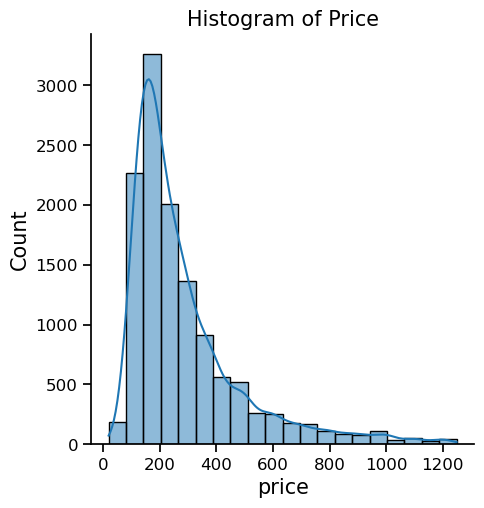

In [9]:
#check the distribution of the response variable: price
plt.figure(figsize=(5, 4))
fig=sns.displot(x = y_train,kde = True, bins = 20)
plt.title('Histogram of Price')
plt.savefig('hist_of_response.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
#since price is right-skewed, we perform log transformation on price
data_train['logprice'] = np.log(data_train['price'])

### <font color = '#e64626'><a id='text'>2.2. Textual Variable</a></font>

In [11]:
# Textual data in this dataset is description， neighborhood_overview and amenities
# 定义一个函数用来分割text(这里仅description， neighborhood_overview)使用
def cut_text(text):
    token=TweetTokenizer()
    tokenized=token.tokenize(text)
    words=[]
    for i in tokenized:
        #将词变为小写
        if i not in string.punctuation:
            i=i.lower()
        # 去词尾词根词缀,删除标点符号
        if i not in stopwords and i not in string.punctuation:
            words.append(PorterStemmer().stem(i))
    return words

In [12]:
# 处理description
for index, row in data_train.iterrows():
    text = row['description']
    cleaned_text = re.sub('<[^<]+?>|\d|‘', '', text)
    data_train.at[index, 'description'] = cleaned_text
data_train['description']=data_train['description'].apply(cut_text)
# 删除html语言的相关代码，删除数字
html_list=["br",'<b>','</b>','’']
num_list=['0','1','2','3','4','5','6','7','8','9',1,2,3,4,5,6,7,8,9,0]
for i in data_train['description']:
    for k in i:
        if k in html_list or i in num_list:
            i.remove(k)

# test set
for index, row in data_test.iterrows():
    text = row['description']
    cleaned_text = re.sub('<[^<]+?>|\d|‘', '', text)
    data_test.at[index, 'description'] = cleaned_text
data_test['description']=data_test['description'].apply(cut_text)
# 删除html语言的相关代码，删除数字
html_list=["br",'<b>','</b>','’']
num_list=['0','1','2','3','4','5','6','7','8','9',1,2,3,4,5,6,7,8,9,0]
for i in data_test['description']:
    for k in i:
        if k in html_list or i in num_list:
            i.remove(k)

In [13]:
# description 高价格房屋词频统计
fre_1=FreqDist()
for i in data_train[data_train['price']>=1000]['description']:
    words_list=ast.literal_eval(str(i))
    for k in words_list:
        fre_1[k]=fre_1[k]+1
print(fre_1.most_common())
# 从词频统计可以看出一些对price可能有影响的词：如beach，park，shop等，最终挑选了20个
# 将这二十个词放入一个列表
des_list=['luxuri','holiday','bay','stun','loung','palm','manli','bondi','byron','spaciou','pool','deck','design','ocean','king','ceil','renov','coastal','bbq','spa']

[('bedroom', 294), ('beach', 279), ('home', 229), ('hous', 223), ('live', 198), ('area', 194), ('walk', 138), ('outdoor', 136), ('pool', 134), ('larg', 129), ('bathroom', 127), ('kitchen', 125), ('bed', 116), ('dine', 116), ('view', 112), ('locat', 111), ('room', 110), ('famili', 108), ('enjoy', 107), ('space', 106), ('privat', 102), ('minut', 101), ('open', 100), ('byron', 90), ('beauti', 89), ('guest', 88), ('perfect', 86), ('relax', 84), ('garden', 83), ('luxuri', 81), ('entertain', 81), ('offer', 75), ('bay', 73), ('deck', 72), ('spaciou', 71), ('holiday', 70), ('s', 70), ('park', 66), ('properti', 66), ('main', 62), ('design', 62), ('king', 60), ('restaur', 59), ('featur', 59), ('shop', 57), ('plan', 55), ('cafe', 54), ('access', 54), ('loung', 53), ('level', 53), ('bbq', 51), ('ocean', 50), ('fulli', 50), ('includ', 50), ('just', 50), ('stun', 49), ('sleep', 49), ('style', 48), ('min', 47), ('new', 46), ('renov', 45), ('floor', 45), ('comfort', 44), ('modern', 43), ('sydney', 43)

In [14]:
# 处理neighborhood_overview
for index, row in data_train.iterrows():
    text = row['neighborhood_overview']
    cleaned_text = re.sub('<[^<]+?>|\d|‘', '', text)
    data_train.at[index, 'neighborhood_overview'] = cleaned_text
data_train['neighborhood_overview']=data_train['neighborhood_overview'].apply(cut_text)
for i in data_train['neighborhood_overview']:
    for k in i:
        if k in html_list or i in num_list:
            i.remove(k)
#Test set
# 处理neighborhood_overview
for index, row in data_test.iterrows():
    text = row['neighborhood_overview']
    cleaned_text = re.sub('<[^<]+?>|\d|‘', '', text)
    data_test.at[index, 'neighborhood_overview'] = cleaned_text
data_test['neighborhood_overview']=data_test['neighborhood_overview'].apply(cut_text)
for i in data_test['neighborhood_overview']:
    for k in i:
        if k in html_list or i in num_list:
            i.remove(k)

In [15]:
# neighborhood_overview 高价格房屋词频统计
fre_2=FreqDist()
for i in data_train[data_train['price']>=1000]['neighborhood_overview']:
    words_list=ast.literal_eval(str(i))
    for k in words_list:
        fre_2[k]=fre_2[k]+1
print(fre_2.most_common())
# 从词频统计可以看出一些对price可能有影响的词：如beach，park，shop等，挑选至少20个
# 最后挑选了54个，将这些词放入一个列表
nei_list = ['byron','bay','surf','ocean','renown','coastal','harbour','holiday','boutiqu','coast','design','stun','manli','palm','bondi','kingscliff','beachsid','lighthous','whale','swim','freshwat','clontarf','queenscliff','darl','pittwat','avalon','casuarina','manly-sid','newport','paddington','berowra','burringbar','myocum','surri','tallow','beachfront','bundeena','belongil','bangalow','golf','court','pacif','tavern','pippi','boomerang','eltham','bront','balmain','pyrmont','sand','sandi','beach','villag','ferri']

[('beach', 262), ('walk', 126), ('minut', 124), ('byron', 117), ('restaur', 108), ('shop', 94), ('cafe', 91), ('bay', 83), ('locat', 81), ('s', 77), ('drive', 76), ('away', 66), ('park', 66), ('sydney', 60), ('just', 59), ('local', 56), ('surf', 53), ('beauti', 53), ('villag', 53), ('hous', 50), ('town', 46), ('close', 45), ('street', 44), ('quiet', 41), ('great', 38), ('area', 38), ('home', 36), ('min', 35), ('enjoy', 34), ('short', 34), ('north', 33), ('best', 33), ('famou', 32), ('bar', 31), ('stroll', 30), ('place', 29), ('swim', 29), ('coast', 29), ('head', 29), ('famili', 28), ('manli', 28), ('love', 27), ('centr', 27), ('world', 27), ('south', 26), ('km', 26), ('includ', 25), ('harbour', 25), ('coffe', 25), ('perfect', 25), ('distanc', 25), ('view', 24), ('holiday', 24), ('citi', 24), ('natur', 24), ('nation', 24), ('market', 23), ('offer', 23), ('dine', 23), ('easi', 23), ('palm', 23), ('popular', 22), ('live', 22), ('surround', 22), ('access', 22), ('main', 22), ('neighbourhoo

In [16]:
# 查看amenities
data_train['amenities']

0        ["Hangers", "Security cameras on property", "A...
1        ["Hot water kettle", "Hot water", "Dining tabl...
2        ["Cooking basics", "TV", "Portable heater", "S...
3        ["Microwave", "Hot water kettle", "Drying rack...
4        ["Toaster", "Hangers", "Central air conditioni...
                               ...                        
12495    ["Microwave", "Hot water kettle", "55\" TV", "...
12496    ["Microwave", "Hot water kettle", "BBQ grill",...
12497    ["Microwave", "Hot water kettle", "Drying rack...
12498    ["Shared gym in building", "Microwave", "Hot w...
12499    ["Toaster", "Hangers", "Sauna", "Free parking ...
Name: amenities, Length: 12500, dtype: object

In [17]:
# count number of keywords in amenities
# The amenities variable is actually a string, not a list, although it looks like a list

# process test set 
#data_test['amenities'] = data_test['amenities'].str.split(',')
def process_amenities(text):
    # 去掉前导和后导的方括号
    text = text.strip('[]')
    text = text.split(',')
    words=[]
    # 使用逗号分割文本，去掉每个词前后的双引号和空格，并返回单词列表
    for i in range(len(text)):
        text[i]=text[i].strip('"')
        text[i]=text[i].strip()
        text[i]=text[i].strip('"')
        words.append(text[i])
    return words

# 在DataFrame中应用处理函数，创建新的列
data_train['amenities'] = data_train['amenities'].apply(process_amenities)
data_test['amenities'] = data_test['amenities'].apply(process_amenities)

In [18]:
# amenities 高价格房屋词频统计
fre_3=FreqDist()
for i in data_train[data_train['price']>=1000]['amenities']:
    words_list=ast.literal_eval(str(i))
    for k in words_list:
        fre_3[k]=fre_3[k]+1
print(fre_3.most_common())
# 从词频统计可以看出一些对price可能有影响的词：如beach，park，shop等，挑选至少20个
# 最后挑选了54个，将这些词放入一个列表
amen_list = ['Private patio or balcony','Dedicated workspace','Wine glasses','Coffee maker','Barbecue utensils','Lockbox','Pets allowed','Private backyard \\u2013 Fully fenced','Luggage dropoff allowed','Backyard','Beach essentials','Blender','High chair','Board games','Garden view','Crib','Private pool','Patio or balcony','Security cameras on property','Central air conditioning','Babysitter recommendations','Sun loungers','Pool view','Waterfront','Private outdoor pool - available all year','Coffee maker: Nespresso','Host greets you','Netflix','Coffee maker: espresso machine','Beach view','Ocean view','Pool','Valley view','Public or shared beach access','Sound system','Private hot tub','Mountain view','Beach access','Private backyard \\u2013 Not fully fenced','Sea view','Disney+','Piano','Fireplace guards','City skyline view','Bay view','Courtyard view','Apple TV','Pool table','Smart lock','Free dryer','Lake access','Park view','River view','AC - split type ductless system']
#amenities和neighborhood overview挑得多是因为本来挑了20个之后看correlation结果相关性比较低，因此多挑了很多词

[('Kitchen', 201), ('Smoke alarm', 195), ('Essentials', 187), ('Wifi', 183), ('Dishes and silverware', 179), ('Iron', 175), ('Hot water', 175), ('Hair dryer', 173), ('Free parking on premises', 171), ('Cooking basics', 171), ('Dishwasher', 165), ('Hangers', 163), ('Microwave', 163), ('Refrigerator', 162), ('Bed linens', 160), ('BBQ grill', 150), ('Washer', 133), ('Outdoor furniture', 133), ('Oven', 132), ('Shampoo', 131), ('Private entrance', 130), ('Heating', 130), ('Fire extinguisher', 125), ('Bathtub', 125), ('Outdoor dining area', 122), ('Self check-in', 120), ('Free street parking', 118), ('Private patio or balcony', 118), ('Extra pillows and blankets', 113), ('First aid kit', 113), ('Hot water kettle', 112), ('Toaster', 108), ('Dining table', 107), ('TV', 106), ('Freezer', 105), ('Dedicated workspace', 104), ('Stove', 103), ('Cleaning products', 103), ('Wine glasses', 101), ('Coffee maker', 99), ('Barbecue utensils', 97), ('Body soap', 94), ('Ceiling fan', 92), ('Lockbox', 91), (

### <font color = '#e64626'><a id='location'>2.3. Location Variable</a></font>

In [19]:
# Location variables in this dataset include neighborhood, latitude, and longtitude
# 处理 neighborhood
    # 查看neighborhood的unique value
data_train['neighbourhood'].value_counts()

neighbourhood
Melbourne              1684
BYRON SHIRE COUNCIL    1013
Sydney                  916
Port Phillip            644
Mid-Coast               553
                       ... 
Camden                   15
Burwood                  14
Holroyd                  13
City Of Kogarah          13
Hunters Hill              8
Name: count, Length: 81, dtype: int64

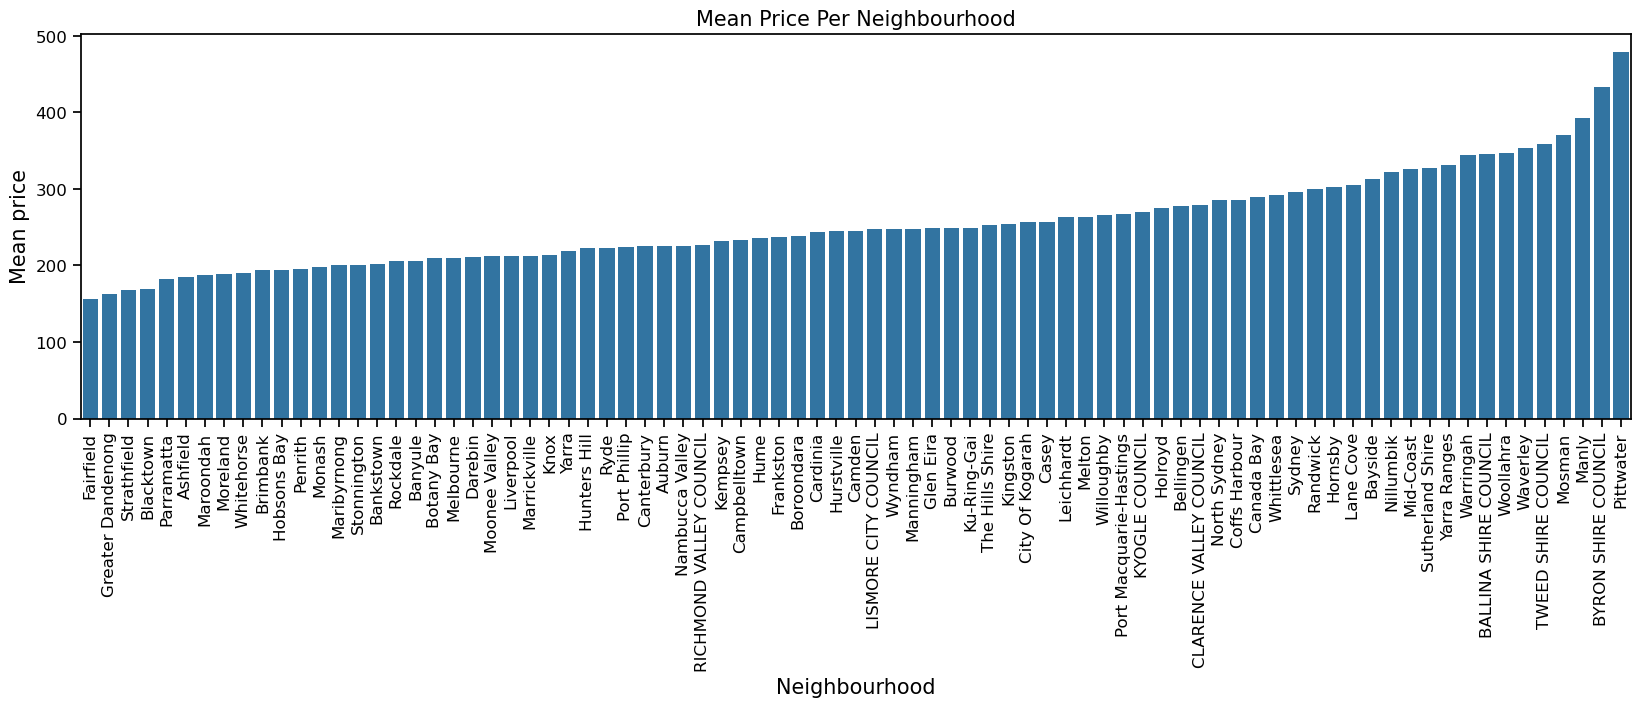

In [20]:
# 查看每个neighborhood的平均房价
mean_price = data_train.groupby('neighbourhood')['price'].mean().sort_values()
plt.figure(figsize=(20, 5))
sns.barplot(x=mean_price.index, y=mean_price.values)
plt.xlabel('Neighbourhood') 
plt.ylabel('Mean price')
plt.xticks(rotation=90)
plt.title('Mean Price Per Neighbourhood')
plt.savefig('mean_p per nei.png', dpi=300, bbox_inches='tight')
plt.show()

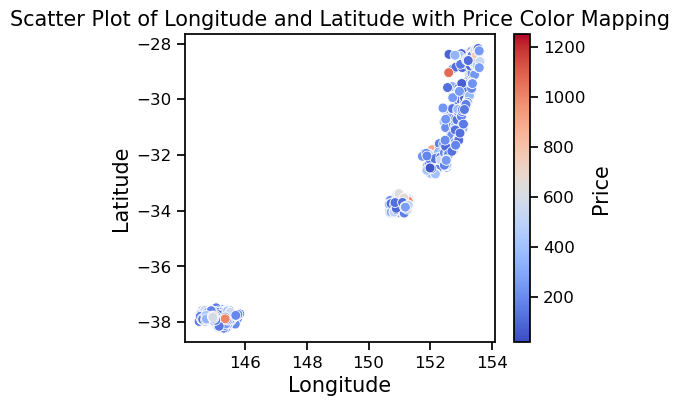

In [21]:
# 处理latitude和longtitude
plt.figure(figsize=(5, 4))
scatter=sns.scatterplot(x='longitude', y='latitude', hue='price', data=data_train, palette='coolwarm', s=50, legend=False)

# 添加标题和标签
plt.title('Scatter Plot of Longitude and Latitude with Price Color Mapping')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# 获取当前图形和轴对象
fig = plt.gcf()
ax = plt.gca()

# 添加 colorbar
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=data_train['price'].min(), vmax=data_train['price'].max()))
sm._A = []
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Price')
plt.show()
# 可以看到经纬度将数据大致分为了三类

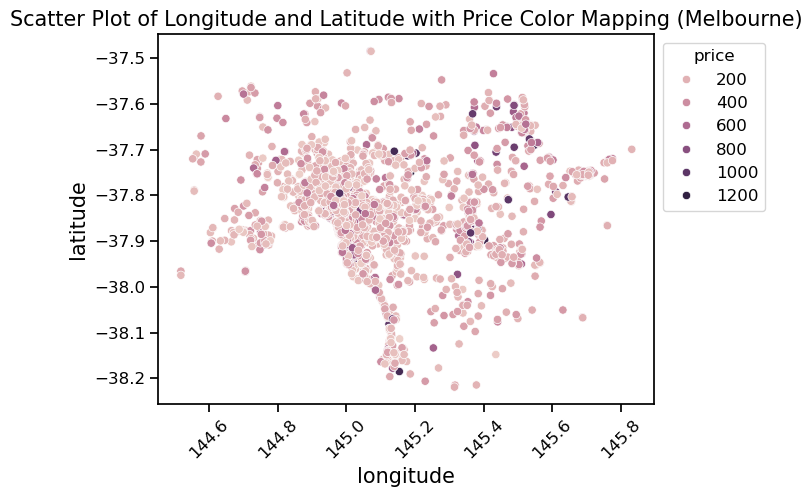

In [22]:
# 墨尔本数据
dtrain_mel = data_train.loc[(data_train['longitude'] <148) & (data_train['latitude'] <-36)]
ax =sns.scatterplot(x = 'longitude', y = 'latitude', data = dtrain_mel, hue = 'price')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.title('Scatter Plot of Longitude and Latitude with Price Color Mapping (Melbourne)')
plt.show()

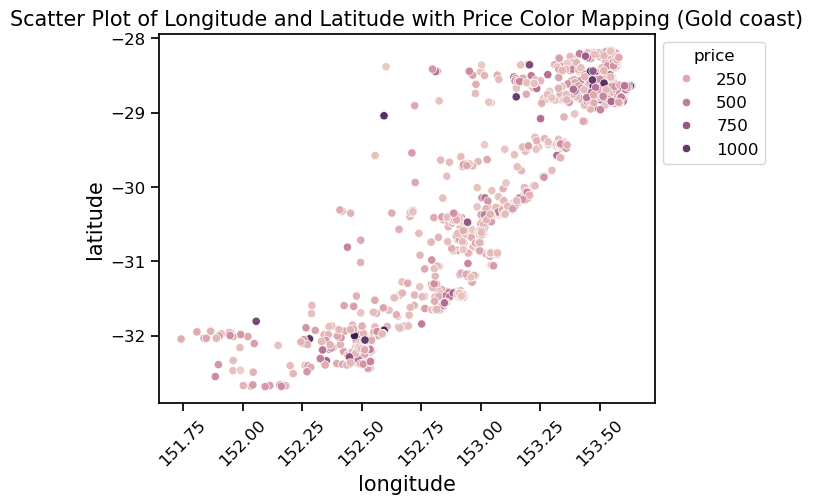

In [23]:
# 黄金海岸数据
dtrain_gdc = data_train.loc[(data_train['longitude'] >151.5) & (data_train['latitude'] >-33)]
ax =sns.scatterplot(x = 'longitude', y = 'latitude', data = dtrain_gdc, hue = 'price')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.title('Scatter Plot of Longitude and Latitude with Price Color Mapping (Gold coast)')
plt.show()

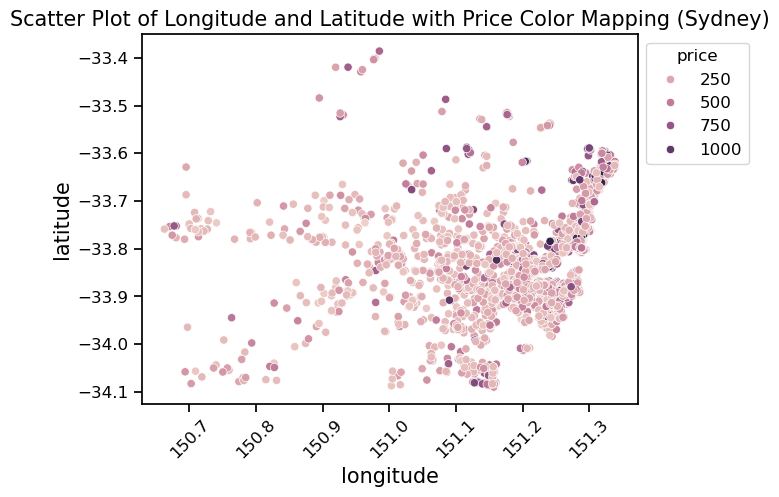

In [24]:
# 悉尼数据
dtrain_syd=data_train.loc[(data_train['longitude'] <151.5) & (data_train['latitude'] <-33)&(data_train['longitude'] >148)&(data_train['latitude'] >-36)]
ax =sns.scatterplot(x = 'longitude', y = 'latitude', data = dtrain_syd, hue = 'price')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.title('Scatter Plot of Longitude and Latitude with Price Color Mapping (Sydney)')
plt.show()

### <font color = '#e64626'><a id='numerical'>2.4. Other Numerical Variable</a></font>

C:\Users\Cayde Li\anaconda3\envs\6810\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 500x400 with 0 Axes>

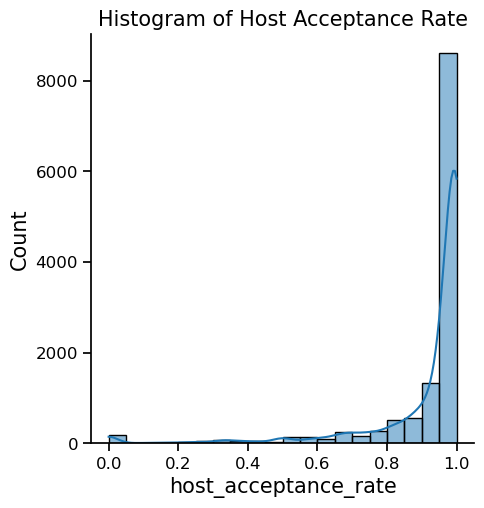

In [25]:
#check the distribution of host_acceptance_rate
plt.figure(figsize=(5, 4))
sns.displot(x = data_train['host_acceptance_rate'],kde = True, bins = 20)
plt.title('Histogram of Host Acceptance Rate')
plt.savefig('hist_of_response.png', dpi=300, bbox_inches='tight')
plt.show()

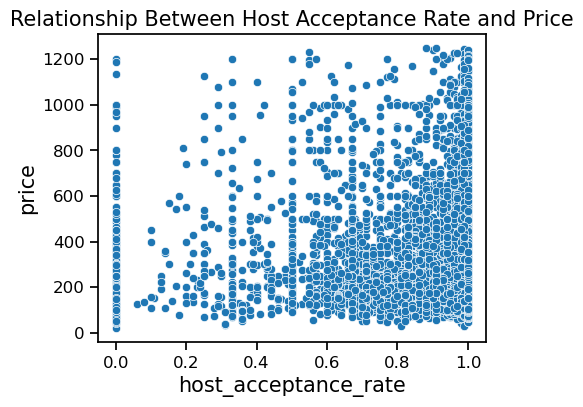

In [26]:
# check the relationship between host_acceptance_rate and price
plt.figure(figsize=(5, 4))
scatter=sns.scatterplot(x='host_acceptance_rate', y='price', data=data_train)
plt.title('Relationship Between Host Acceptance Rate and Price')
plt.xlabel('host_acceptance_rate')
plt.ylabel('price')
plt.savefig('scatter_ha_p.png', dpi=300, bbox_inches='tight')
plt.show()

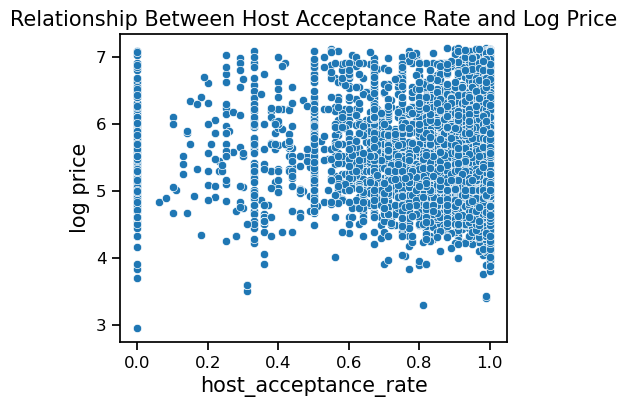

In [27]:
# check the relationship between host_acceptance_rate and log price
plt.figure(figsize=(5, 4))
scatter=sns.scatterplot(x='host_acceptance_rate', y='logprice', data=data_train)
plt.title('Relationship Between Host Acceptance Rate and Log Price')
plt.xlabel('host_acceptance_rate')
plt.ylabel('log price')
plt.savefig('scatter_ha_lp.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Cayde Li\anaconda3\envs\6810\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


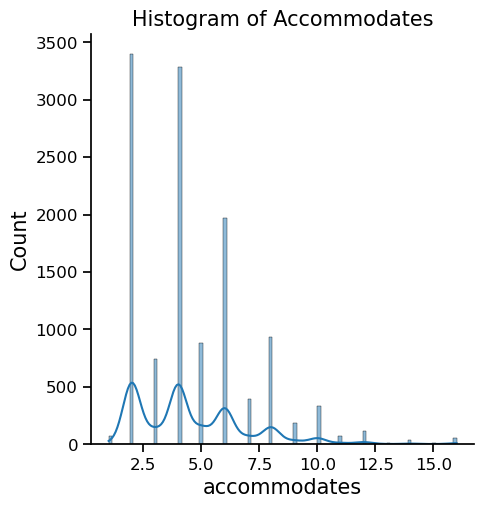

In [28]:
#the distribution of variable accommodates
fig = sns.displot(x = 'accommodates', data = data_train,kde = True, bins = 100)
plt.title('Histogram of Accommodates')
plt.savefig('hist_of_response.png', dpi=300, bbox_inches='tight')
plt.show()

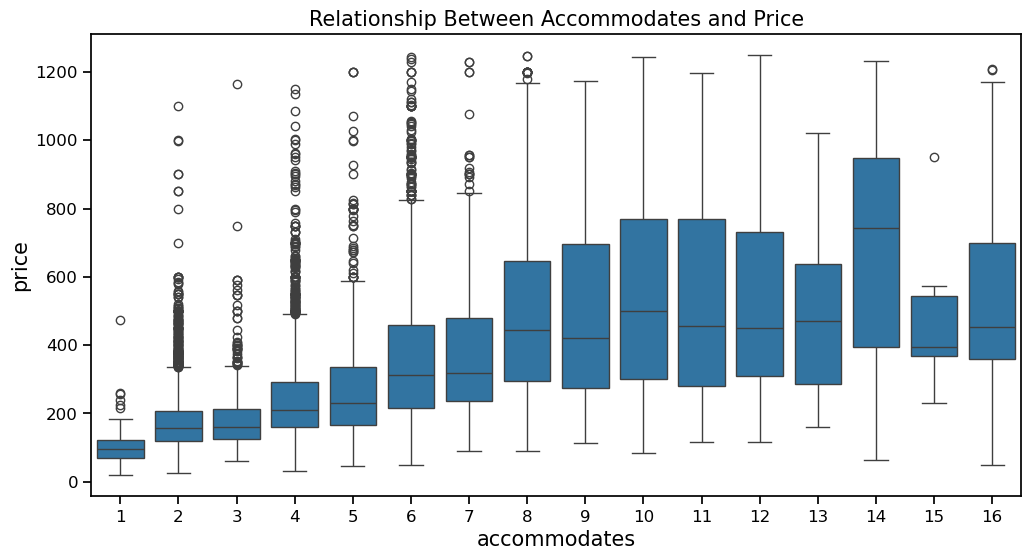

In [29]:
# check the relationship between accommodates and price
plt.figure(figsize=(12, 6))
ax=sns.boxplot(x='accommodates', y='price', data=data_train)
plt.title('Relationship Between Accommodates and Price')
plt.xlabel('accommodates')
plt.ylabel('price')
plt.savefig('boxplot_a_p.png', dpi=300, bbox_inches='tight')
plt.show()

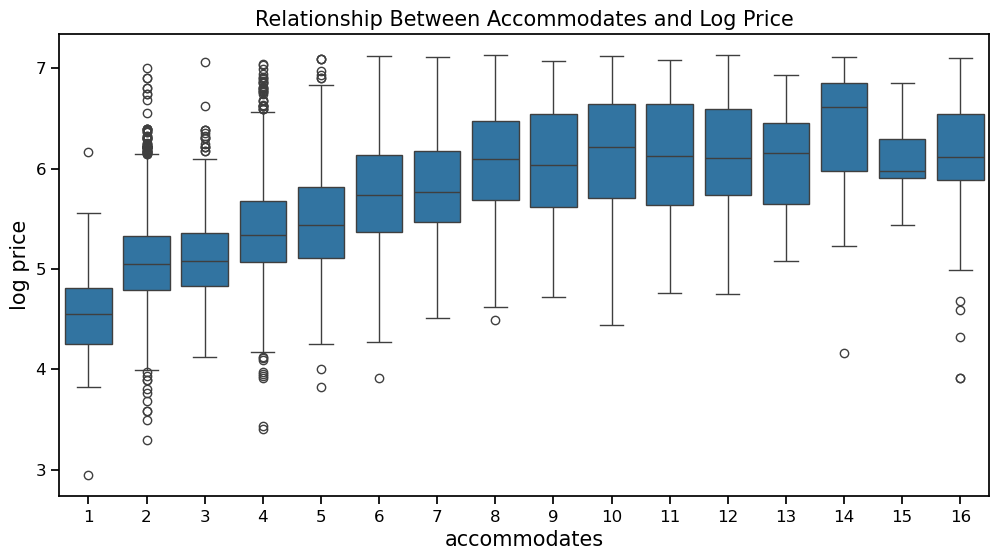

In [30]:
# check the relationship between accommodates and log price
plt.figure(figsize=(12, 6))
scatter=sns.boxplot(x='accommodates', y='logprice', data=data_train)
plt.title('Relationship Between Accommodates and Log Price')
plt.xlabel('accommodates')
plt.ylabel('log price')
plt.savefig('boxplot_a_lp.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Cayde Li\anaconda3\envs\6810\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


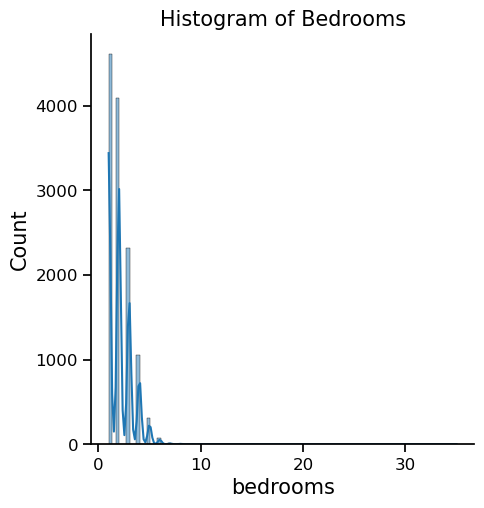

In [31]:
#the distribution of variable accommodates
fig = sns.displot(x = 'bedrooms', data = data_train,kde = True, bins = 100)
plt.title('Histogram of Bedrooms')
plt.savefig('hist_of_bedroom.png', dpi=300, bbox_inches='tight')
plt.show()

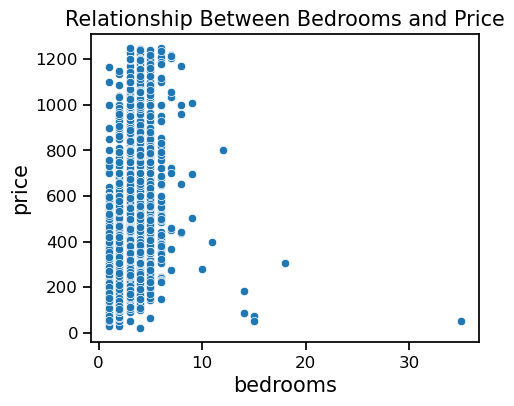

In [32]:
# check the relationship between bedrooms and price
plt.figure(figsize=(5, 4))
scatter=sns.scatterplot(x='bedrooms', y='price', data=data_train)
plt.title('Relationship Between Bedrooms and Price')
plt.xlabel('bedrooms')
plt.ylabel('price')
plt.savefig('scatter_b_p.png', dpi=300, bbox_inches='tight')
plt.show()
# 发现有outlier

In [33]:
#drop extreme value (AKA listing with 35 bedrooms)
data_train = data_train.drop(data_train[data_train['bedrooms'] > 12].index)

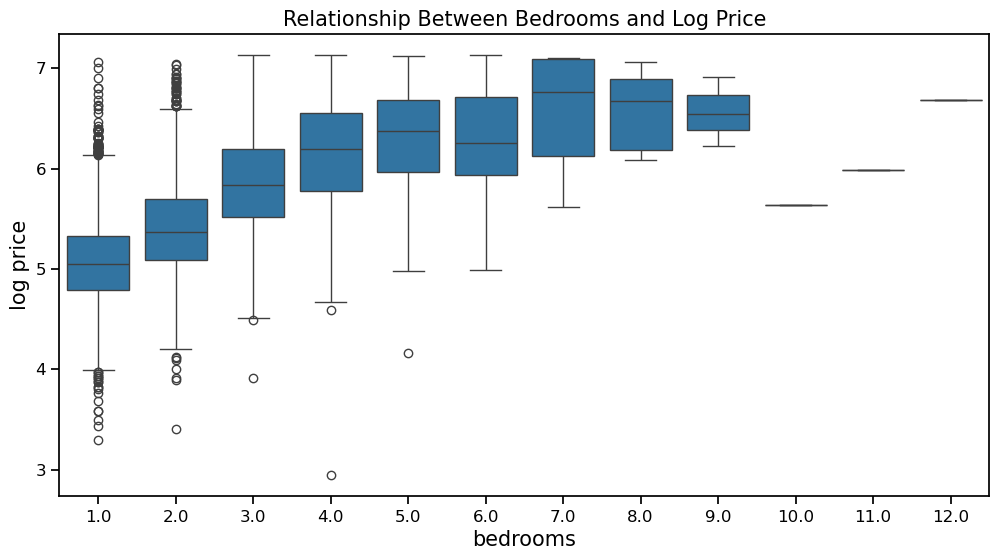

In [34]:
# check the relationship between bedrooms and log price
plt.figure(figsize=(12, 6))
scatter=sns.boxplot(x='bedrooms', y='logprice', data=data_train)
plt.title('Relationship Between Bedrooms and Log Price')
plt.xlabel('bedrooms')
plt.ylabel('log price')
plt.savefig('boxplot_b_lp.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Cayde Li\anaconda3\envs\6810\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


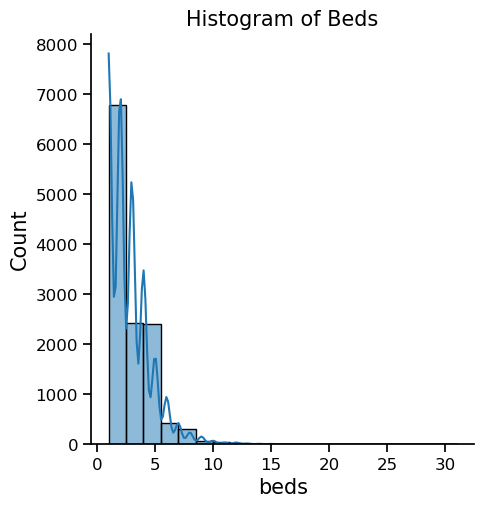

In [35]:
#the distribution of variable accommodates
fig = sns.displot(x = 'beds', data = data_train,kde = True, bins = 20)
plt.title('Histogram of Beds')
plt.savefig('hist_of_bedroom.png', dpi=300, bbox_inches='tight')
plt.show()

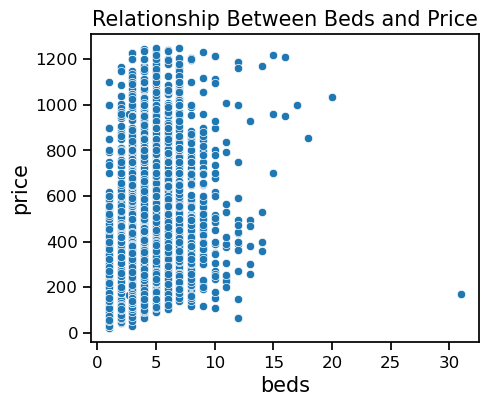

In [36]:
# check the relationship between beds and price
plt.figure(figsize=(5, 4))
scatter=sns.scatterplot(x='beds', y='price', data=data_train)
plt.title('Relationship Between Beds and Price')
plt.xlabel('beds')
plt.ylabel('price')
plt.savefig('scatter_bs_p.png', dpi=300, bbox_inches='tight')
plt.show()
# 发现有outlier

In [37]:
data_train[data_train['beds'] > 20]
#查看后决定删除

id  price                                        description  \
8792  11292    169  [charm, share, home, offer, cozi, spaciou, bed...   

                                  neighborhood_overview  host_acceptance_rate  \
8792  [quiet, peac, suburb, west, melbourn, km, easi...                  0.77   

     neighbourhood   latitude   longitude property_type        room_type  ...  \
8792      Brimbank -37.761819  144.772296   Entire home  Entire home/apt  ...   

      bedrooms  beds                                          amenities  \
8792       3.0  31.0  [Microwave, Hot water kettle, BBQ grill, Dryin...   

     minimum_nights  maximum_nights  number_of_reviews  \
8792              1             365                  1   

      review_scores_cleanliness  review_scores_communication  \
8792                        3.0                          5.0   

      review_scores_location  logprice  
8792                     3.0  5.129899  

[1 rows x 21 columns]

In [38]:
#删除outliers
data_train = data_train.drop(data_train[data_train['beds'] > 20].index)


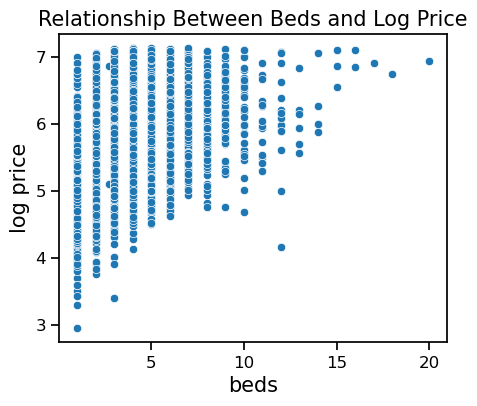

In [39]:
# check the relationship between beds and log price
plt.figure(figsize=(5, 4))
scatter=sns.scatterplot(x='beds', y='logprice', data=data_train)
plt.title('Relationship Between Beds and Log Price')
plt.xlabel('beds')
plt.ylabel('log price')
plt.savefig('scatter_bs_lp.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Cayde Li\anaconda3\envs\6810\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


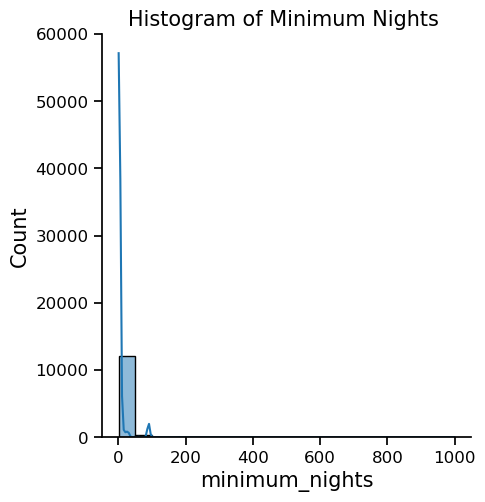

In [40]:
#the distribution of variable minimum_nights 
fig = sns.displot(x = 'minimum_nights', data = data_train,kde = True, bins = 20)
plt.title('Histogram of Minimum Nights ')
plt.savefig('hist_of_minimum_nights.png', dpi=300, bbox_inches='tight')
plt.show()

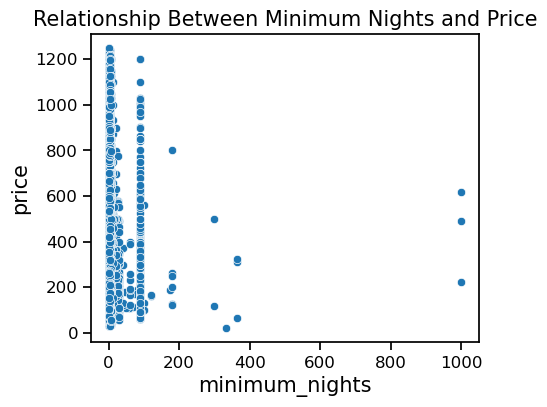

In [41]:
# check the relationship between minimum_nights and price
plt.figure(figsize=(5, 4))
scatter=sns.scatterplot(x='minimum_nights', y='price', data=data_train)
plt.title('Relationship Between Minimum Nights and Price')
plt.xlabel('minimum_nights')
plt.ylabel('price')
plt.savefig('scatter_mn_p.png', dpi=300, bbox_inches='tight')
plt.show()
# 发现有outlier

In [42]:
data_train[data_train['minimum_nights'] > 900]
# 查看后感觉正常，不删除

id  price                                        description  \
5424    7924    489  [collabor, australia, s, respect, furnitur, ho...   
10806  13306    619  [collabor, australia, s, respect, furnitur, ho...   
11068  13568    222  [arcadia, hous, –, beauti, guesthous, accommod...   

                                   neighborhood_overview  \
5424   [pott, point, cosmopolitan, enclav, walkabl, d...   
10806  [pott, point, cosmopolitan, enclav, drench, cl...   
11068  [easi, minut, walk, beach, town, arcadia, posi...   

       host_acceptance_rate        neighbourhood   latitude   longitude  \
5424                    1.0               Sydney -33.868858  151.225403   
10806                   1.0               Sydney -33.869460  151.224530   
11068                   1.0  BYRON SHIRE COUNCIL -28.650840  153.618390   

                   property_type        room_type  ...  bedrooms  beds  \
5424   Entire serviced apartment  Entire home/apt  ...       2.0   2.0   
10806  Entire serviced apartment  Entire home/apt  ...       3.0   3.0   
11068       Private room in home     Private room  ...       6.0   1.0   

                                               amenities minimum_nights  \
5424   [Toaster, Hangers, Electric stove, Bluetooth s...            999   
10806  [Toaster, Hangers, First aid kit, Heating, Ind...            999   
11068  [Carbon monoxide alarm, Fire extinguisher, Sel...            999   

       maximum_nights  number_of_reviews  review_scores_cleanliness  \
5424             1125                 32                       4.81   
10806            1125                 41                       4.61   
11068            1125                 10                       4.70   

       review_scores_communication  review_scores_location  logprice  
5424                          4.94                    4.97  6.192362  
10806                         4.88                    4.93  6.428105  
11068                         4.70                    4.90  5.402677  

[3 rows x 21 columns]

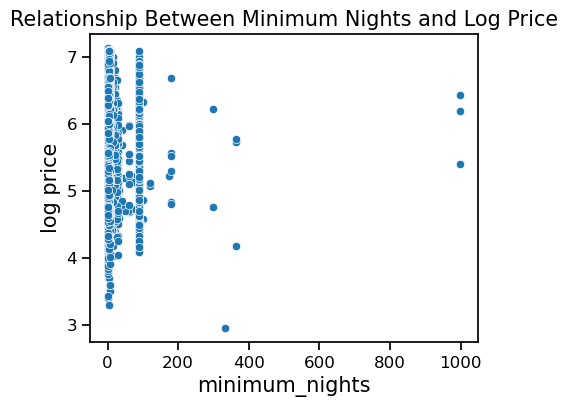

In [43]:
# check the relationship between minimum_nights and log price
plt.figure(figsize=(5, 4))
scatter=sns.scatterplot(x='minimum_nights', y='logprice', data=data_train)
plt.title('Relationship Between Minimum Nights and Log Price')
plt.xlabel('minimum_nights')
plt.ylabel('log price')
plt.savefig('scatter_bs_lp.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Cayde Li\anaconda3\envs\6810\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


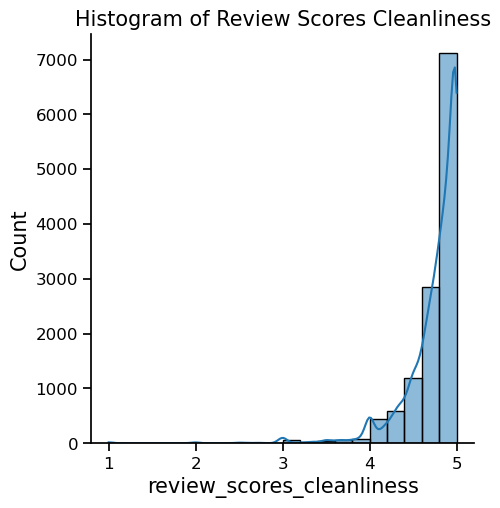

In [44]:
#the distribution of variable review_scores_cleanliness 
fig = sns.displot(x = 'review_scores_cleanliness', data = data_train,kde = True, bins = 20)
plt.title('Histogram of Review Scores Cleanliness')
plt.savefig('hist_review_scores_cleanliness.png', dpi=300, bbox_inches='tight')
plt.show()
# 数据左偏

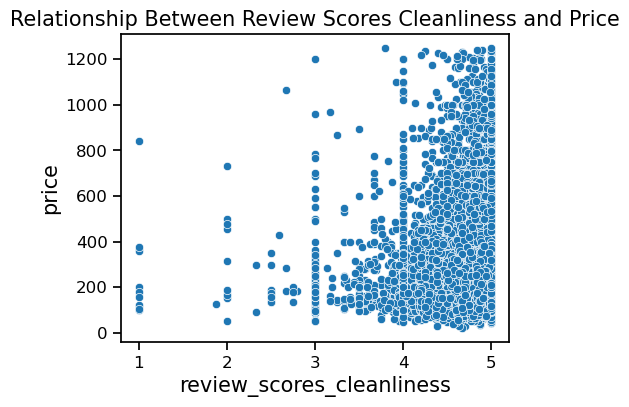

In [45]:
# check the relationship between review_scores_cleanliness and price
plt.figure(figsize=(5, 4))
scatter=sns.scatterplot(x='review_scores_cleanliness', y='price', data=data_train)
plt.title('Relationship Between Review Scores Cleanliness and Price')
plt.xlabel('review_scores_cleanliness')
plt.ylabel('price')
plt.savefig('scatter_rsc_p.png', dpi=300, bbox_inches='tight')
plt.show()

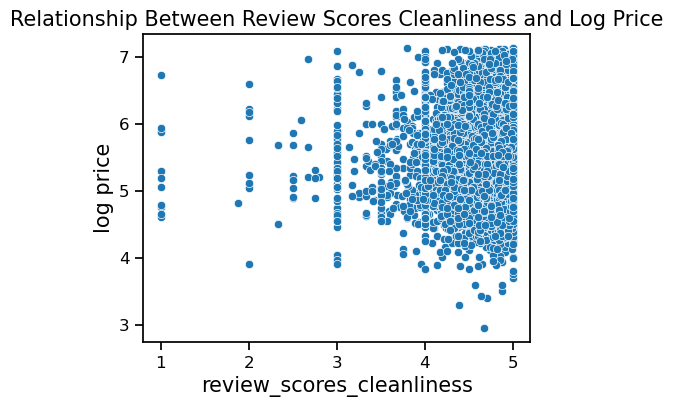

In [46]:
# check the relationship between review_scores_cleanliness and log price
plt.figure(figsize=(5, 4))
scatter=sns.scatterplot(x='review_scores_cleanliness', y='logprice', data=data_train)
plt.title('Relationship Between Review Scores Cleanliness and Log Price')
plt.xlabel('review_scores_cleanliness')
plt.ylabel('log price')
plt.savefig('scatter_rsc_lp.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Cayde Li\anaconda3\envs\6810\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


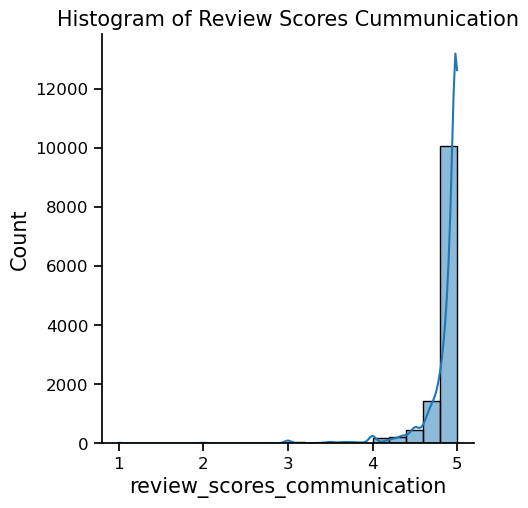

In [47]:
#the distribution of variable review_scores_communication 
fig = sns.displot(x = 'review_scores_communication', data = data_train,kde = True, bins = 20)
plt.title('Histogram of Review Scores Cummunication')
plt.savefig('hist_review_scores_communication.png', dpi=300, bbox_inches='tight')
plt.show()

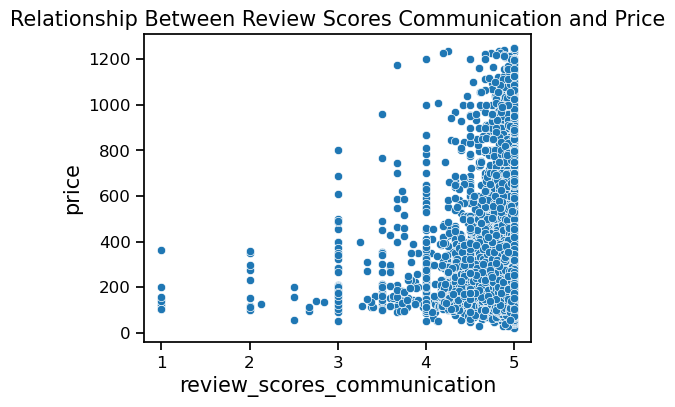

In [48]:
# check the relationship between review_scores_communication and price
plt.figure(figsize=(5, 4))
scatter=sns.scatterplot(x='review_scores_communication', y='price', data=data_train)
plt.title('Relationship Between Review Scores Communication and Price')
plt.xlabel('review_scores_communication')
plt.ylabel('price')
plt.savefig('scatter_rsco_p.png', dpi=300, bbox_inches='tight')
plt.show()

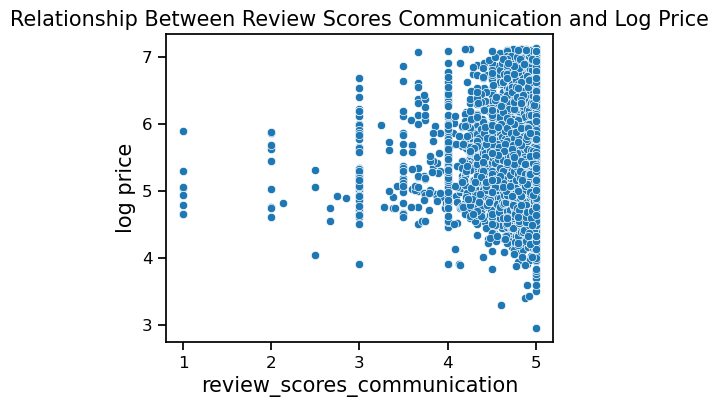

In [49]:
# check the relationship between review_scores_communication and log price
plt.figure(figsize=(5, 4))
scatter=sns.scatterplot(x='review_scores_communication', y='logprice', data=data_train)
plt.title('Relationship Between Review Scores Communication and Log Price')
plt.xlabel('review_scores_communication')
plt.ylabel('log price')
plt.savefig('scatter_rsco_lp.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Cayde Li\anaconda3\envs\6810\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


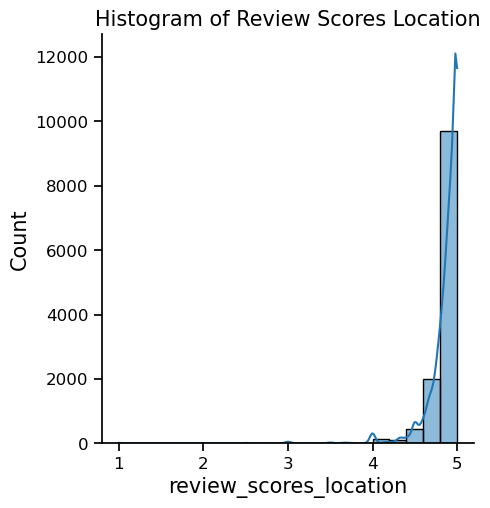

In [50]:
#the distribution of variable review_scores_location 
fig = sns.displot(x = 'review_scores_location', data = data_train,kde = True, bins = 20)
plt.title('Histogram of Review Scores Location')
plt.savefig('hist_review_scores_location.png', dpi=300, bbox_inches='tight')
plt.show()

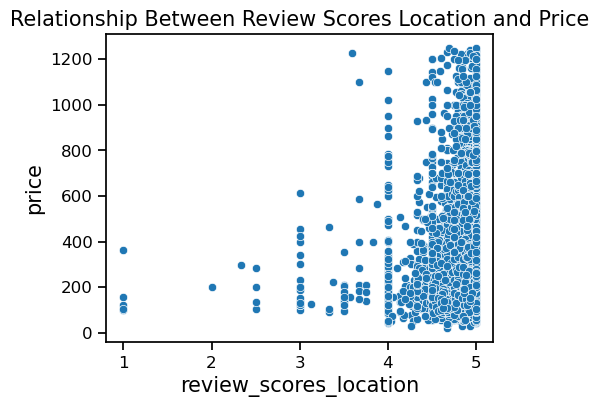

In [51]:
# check the relationship between review_scores_location and price
plt.figure(figsize=(5, 4))
scatter=sns.scatterplot(x='review_scores_location', y='price', data=data_train)
plt.title('Relationship Between Review Scores Location and Price')
plt.xlabel('review_scores_location')
plt.ylabel('price')
plt.savefig('scatter_rsl_p.png', dpi=300, bbox_inches='tight')
plt.show()

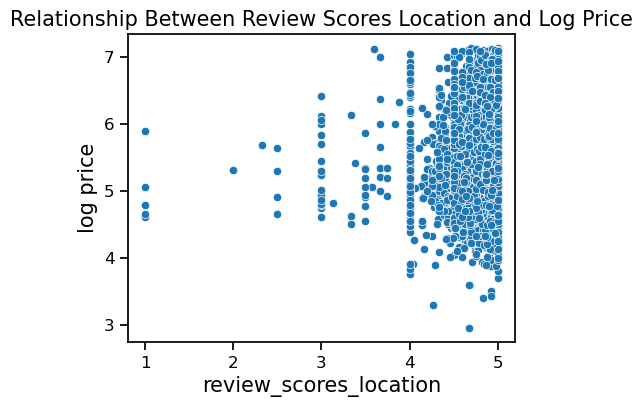

In [52]:
# check the relationship between review_scores_location and log price
plt.figure(figsize=(5, 4))
scatter=sns.scatterplot(x='review_scores_location', y='logprice', data=data_train)
plt.title('Relationship Between Review Scores Location and Log Price')
plt.xlabel('review_scores_location')
plt.ylabel('log price')
plt.savefig('scatter_rsl_lp.png', dpi=300, bbox_inches='tight')
plt.show()

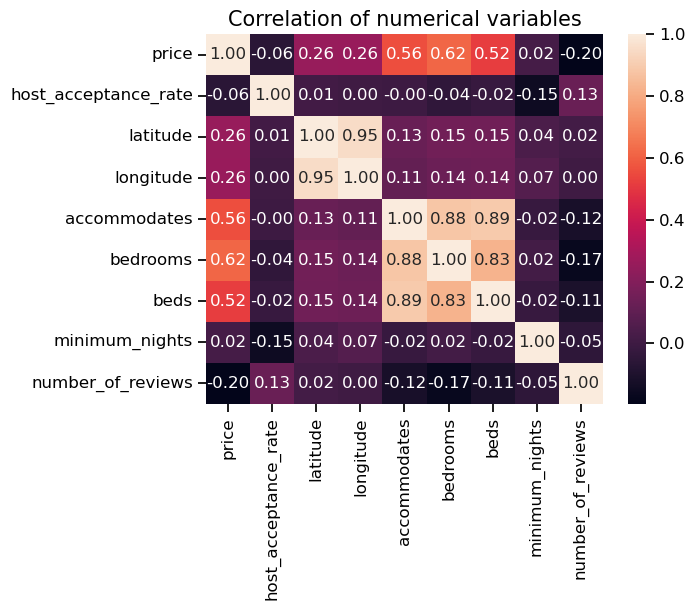

In [53]:
#Check the correlation between each numerical variables
sns.heatmap(data_train[['price','host_acceptance_rate','latitude','longitude','accommodates','bedrooms','beds'
                        ,'minimum_nights','number_of_reviews']].corr(), annot=True, fmt='.2f')
plt.title('Correlation of numerical variables')
plt.show()

### <font color = '#e64626'><a id='categorical'>2.5. Other Categorical Variable</a></font>

In [54]:
# Show the information of Categorical variable（property_type和room_type）
print("Property_type unique values: ")
print(data_train['property_type'].unique())
print("Room_type unique values:")
print(data_train['room_type'].unique())
#发现Property type的信息包含 room type, 将在feature engineering做进一步处理

Property_type unique values: 
['Entire guesthouse' 'Entire rental unit' 'Entire bungalow'
 'Private room in guest suite' 'Tent' 'Entire home' 'Entire guest suite'
 'Entire townhouse' 'Private room in guesthouse' 'Entire condo'
 'Entire cottage' 'Entire villa' 'Entire chalet' 'Room in hotel'
 'Entire vacation home' 'Entire loft' 'Entire cabin'
 'Private room in home' 'Farm stay' 'Entire serviced apartment'
 'Room in boutique hotel' 'Private room' 'Tiny home' 'Shipping container'
 'Private room in rental unit' 'Yurt' 'Room in serviced apartment'
 'Private room in serviced apartment' 'Barn' 'Earthen home' 'Entire place'
 'Camper/RV' 'Train' 'Private room in hostel' 'Private room in townhouse'
 'Room in bed and breakfast' 'Private room in loft' 'Room in hostel'
 'Room in aparthotel' 'Holiday park' 'Boat' 'Campsite' 'Ranch' 'Bus'
 'Entire bed and breakfast' 'Private room in tipi'
 'Private room in camper/rv' 'Private room in tent' 'Nature lodge' 'Hut'
 'Private room in condo' 'Treehouse' 'P

C:\Users\Cayde Li\anaconda3\envs\6810\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


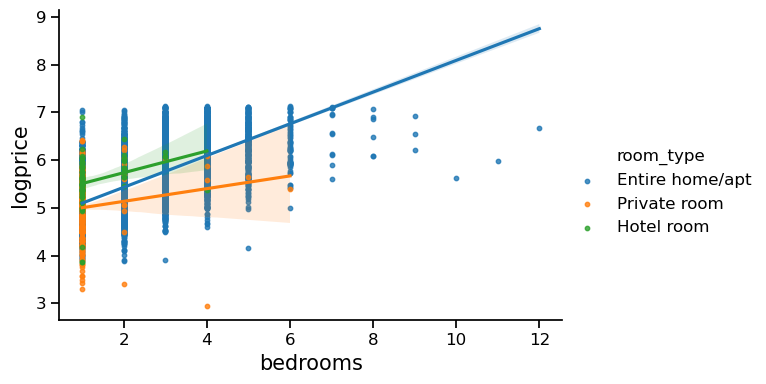

In [55]:
#Check how room type interact with price
fig = sns.lmplot(x = 'bedrooms',y = 'logprice', hue = 'room_type',data = data_train,height=4, aspect=1.5, scatter_kws={'s': 10})

## <font color = '#e64626'><a id='feature_engineering'>3. Feature Engineering</a></font>

In [56]:
# 创建一个新列 description_word_count
data_train['description_word_count'] = 0

# 逐行遍历数据集，计算词频
for index, row in data_train.iterrows():
    description = row['description']
    count = 0
    for word in description:
        if word in des_list:
            count += 1
    data_train.at[index, 'description_word_count'] = count

# Test set
data_test['description_word_count'] = 0

# 逐行遍历数据集，计算词频
for index, row in data_test.iterrows():
    description = row['description']
    count = 0
    for word in description:
        if word in des_list:
            count += 1
    data_test.at[index, 'description_word_count'] = count
data_train['description_word_count']

0        2
1        4
2        2
3        4
4        4
        ..
12495    0
12496    4
12497    0
12498    5
12499    3
Name: description_word_count, Length: 12492, dtype: int64

In [57]:
# 创建一个新列 neighborhood_overview_word_count
data_train['neighborhood_overview_word_count'] = 0
# 逐行遍历数据集，计算词频
for index, row in data_train.iterrows():
    description = row['neighborhood_overview']
    count = 0
    for word in description:
        if word in nei_list:
            count += 1
    data_train.at[index, 'neighborhood_overview_word_count'] = count

#test set
data_test['neighborhood_overview_word_count'] = 0
# 逐行遍历数据集，计算词频
for index, row in data_test.iterrows():
    description = row['neighborhood_overview']
    count = 0
    for word in description:
        if word in nei_list:
            count += 1
    data_test.at[index, 'neighborhood_overview_word_count'] = count
data_train['neighborhood_overview_word_count']

0        8
1        0
2        5
3        0
4        4
        ..
12495    0
12496    0
12497    1
12498    2
12499    2
Name: neighborhood_overview_word_count, Length: 12492, dtype: int64

In [58]:
# 创建一个新列 amenities_word_count
data_train['amenities_word_count'] = 0
# 逐行遍历数据集，计算词频
for index, row in data_train.iterrows():
    description = row['amenities']
    count = 0
    for word in description:
        if word in amen_list:
            count += 1
    data_train.at[index, 'amenities_word_count'] = count

#test set
data_test['amenities_word_count'] = 0
# 逐行遍历数据集，计算词频
for index, row in data_test.iterrows():
    description = row['amenities']
    count = 0
    for word in description:
        if word in amen_list:
            count += 1
    data_test.at[index, 'amenities_word_count'] = count
data_train['amenities_word_count']

0         8
1         1
2         1
3         6
4         8
         ..
12495     4
12496    12
12497     8
12498    11
12499     5
Name: amenities_word_count, Length: 12492, dtype: int64

In [59]:
#build a function to get the (haversine) distance from the listing to the center of city
def haversine_d(listing, CBD):
    listing_in_radians = [radians(_) for _ in listing]
    CBD_in_radians = [radians(_) for _ in CBD]
    result = haversine_distances([listing_in_radians,CBD_in_radians])
    result = result*6371000/1000
    return result[0][1]

In [60]:
#The coordinates of CBD of Melbourne, Sydney, and Gold coast
mel_co = [-37.814,144.96332]
syd_co = [-33.868056,151.212222]
gdc_co =[-28.016666,153.399994]

In [61]:
# calculate the distance to the nearest CBD
d_to_CBD_train = []
for i in range(data_train.shape[0]):
    listing = [data_train.iloc[i,6],data_train.iloc[i,7]]
    if (listing[0] < -36):
        d_to_CBD_train.append(round(haversine_d(listing,mel_co),5));
    elif (listing[0] > -33):
        d_to_CBD_train.append(round(haversine_d(listing,gdc_co),5));
    else:
        d_to_CBD_train.append(round(haversine_d(listing,syd_co),5));

d_to_CBD_test = []
for i in range(data_test.shape[0]):
    listing = [data_test.iloc[i,5],data_test.iloc[i,6]]
    if (listing[0] < -36):
        d_to_CBD_test.append(round(haversine_d(listing,mel_co),5));
    elif (listing[0] > -33):
        d_to_CBD_test.append(round(haversine_d(listing,gdc_co),5));
    else:
        d_to_CBD_test.append(round(haversine_d(listing,syd_co),5));

data_train['distance to CBD'] = d_to_CBD_train
data_test['distance to CBD'] = d_to_CBD_test


In [62]:
# 创建一个平均分列
data_train['review_score_mean']=(data_train['review_scores_location']+data_train['review_scores_cleanliness']+data_train['review_scores_communication'])/3
data_test['review_score_mean']=(data_test['review_scores_location']+data_test['review_scores_cleanliness']+data_test['review_scores_communication'])/3

In [63]:
# 将review score所有变量转换为ordinal data，1-3为low，3-4为medium，4-5为high
# 根据规则定义分箱的边界和标签
bins = [0, 3, 4, 5]
labels = ["low", "medium", "high"]

# 使用pd.cut()函数将review_score分箱
data_train['review_score_mean_cut'] = pd.cut(data_train['review_score_mean'], bins=bins, labels=labels)
data_train['review_scores_location_cut'] = pd.cut(data_train['review_scores_location'], bins=bins, labels=labels)
data_train['review_scores_cleanliness_cut'] = pd.cut(data_train['review_scores_cleanliness'], bins=bins, labels=labels)
data_train['review_scores_communication_cut'] = pd.cut(data_train['review_scores_communication'], bins=bins, labels=labels)
data_test['review_score_mean_cut'] = pd.cut(data_test['review_score_mean'], bins=bins, labels=labels)
data_test['review_scores_location_cut'] = pd.cut(data_test['review_scores_location'], bins=bins, labels=labels)
data_test['review_scores_cleanliness_cut'] = pd.cut(data_test['review_scores_cleanliness'], bins=bins, labels=labels)
data_test['review_scores_communication_cut'] = pd.cut(data_test['review_scores_communication'], bins=bins, labels=labels)

In [64]:
# 处理property_type
pd.set_option('display.max_rows', None)
data_train['property_type'].value_counts()

property_type
Entire rental unit                    5323
Entire home                           3326
Entire guest suite                     576
Entire guesthouse                      546
Entire condo                           436
Entire townhouse                       435
Entire cottage                         331
Entire serviced apartment              261
Farm stay                              143
Entire villa                           132
Room in boutique hotel                  97
Entire cabin                            97
Entire vacation home                    94
Entire loft                             83
Room in hotel                           82
Entire bungalow                         76
Tiny home                               65
Private room in home                    42
Room in aparthotel                      36
Private room in guesthouse              28
Private room in hostel                  26
Room in serviced apartment              26
Entire place                            

In [65]:
#combine all those words appeared less than 100 times to other in property type
property_type = data_train['property_type'].value_counts().index[:10]

for i in range(data_train.shape[0]):
    if data_train.iloc[i,8] in property_type:
        pass;
    else:
        data_train.iloc[i,8] = 'others'

for i in range(data_test.shape[0]):
    if data_test.iloc[i,7] in property_type:
        pass;
    else:
        data_test.iloc[i,7] = 'others'

In [66]:
#combine private room and hotel room in room type as single room
room_type = data_train['room_type'].value_counts().index[0]
for i in range(data_train.shape[0]):
    if data_train.iloc[i,9] in room_type:
        pass;
    else:
        data_train.iloc[i,9] = 'single room'

for i in range(data_test.shape[0]):
    if data_test.iloc[i,8] in room_type:
        pass;
    else:
        data_test.iloc[i,8] = 'single room'

In [67]:
data_train['neighbourhood'].value_counts()[45]

C:\Users\Cayde Li\AppData\Local\Temp\ipykernel_20800\4057158104.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_train['neighbourhood'].value_counts()[45]


51

In [68]:
#combine all neighbourhood quantity less than 51
neighbourhood_type = data_train['neighbourhood'].value_counts().index[:45]
for i in range(data_train.shape[0]):
    if data_train.iloc[i,5] in neighbourhood_type:
        pass;
    else:
        data_train.iloc[i,5] = 'Others'

for i in range(data_test.shape[0]):
    if data_test.iloc[i,4] in neighbourhood_type:
        pass;
    else:
        data_test.iloc[i,4] = 'Others'

In [69]:
data_train['neighbourhood'].value_counts()

neighbourhood
Melbourne                  1684
BYRON SHIRE COUNCIL        1012
Others                      985
Sydney                      916
Port Phillip                644
Mid-Coast                   551
TWEED SHIRE COUNCIL         467
Waverley                    427
Yarra Ranges                419
Yarra                       385
Stonnington                 374
Coffs Harbour               350
Port Macquarie-Hastings     271
CLARENCE VALLEY COUNCIL     269
Pittwater                   252
BALLINA SHIRE COUNCIL       242
Manly                       233
Randwick                    231
Warringah                   230
Moreland                    163
North Sydney                159
Woollahra                   150
Sutherland Shire            137
Leichhardt                  134
Kempsey                     121
Nambucca Valley             113
Maribyrnong                 103
Marrickville                 98
Bellingen                    98
Glen Eira                    96
Boroondara                

In [70]:
#做完feature engineering后把之前用过的列都删掉，因为后面要搞dummy variable
data_train = data_train.drop(columns=['description','neighborhood_overview','review_scores_location','review_scores_communication','review_scores_cleanliness','review_score_mean','review_scores_location_cut','review_scores_cleanliness_cut','review_scores_communication_cut','id','amenities'])
data_test = data_test.drop(columns=['description','neighborhood_overview','review_scores_location','review_scores_communication','review_scores_cleanliness','review_score_mean','review_scores_location_cut','review_scores_cleanliness_cut','review_scores_communication_cut','id','amenities'])

In [71]:
data_train.head()

price  host_acceptance_rate  neighbourhood   latitude   longitude  \
0    260                  0.67          Manly -33.793440  151.280990   
1    264                  0.98          Yarra -37.798788  145.000433   
2    130                  0.88  Coffs Harbour -30.154650  153.019150   
3    171                  1.00      Melbourne -37.807930  144.961110   
4    194                  0.99       Waverley -33.890310  151.270760   

        property_type        room_type  accommodates  bedrooms  beds  \
0   Entire guesthouse  Entire home/apt             2       1.0   1.0   
1  Entire rental unit  Entire home/apt             2       1.0   3.0   
2   Entire guesthouse  Entire home/apt             3       2.0   2.0   
3  Entire rental unit  Entire home/apt             6       2.0   4.0   
4  Entire rental unit  Entire home/apt             2       1.0   1.0   

   minimum_nights  maximum_nights  number_of_reviews  logprice  \
0               4            1125                  3  5.560682   
1               5            1125                  2  5.575949   
2               2            1125                 29  4.867534   
3               1            1125                290  5.141664   
4               2              90                 25  5.267858   

   description_word_count  neighborhood_overview_word_count  \
0                       2                                 8   
1                       4                                 0   
2                       2                                 5   
3                       4                                 0   
4                       4                                 4   

   amenities_word_count  distance to CBD review_score_mean_cut  
0                     8         10.44923                  high  
1                     1          3.67318                medium  
2                     1        240.59556                  high  
3                     6          0.70232                  high  
4                     8          5.94359                  high

In [72]:
# 取numerical variables
num_var = ['host_acceptance_rate','latitude','longitude','accommodates','bedrooms','beds','amenities_word_count','minimum_nights','maximum_nights','description_word_count','neighborhood_overview_word_count','distance to CBD']

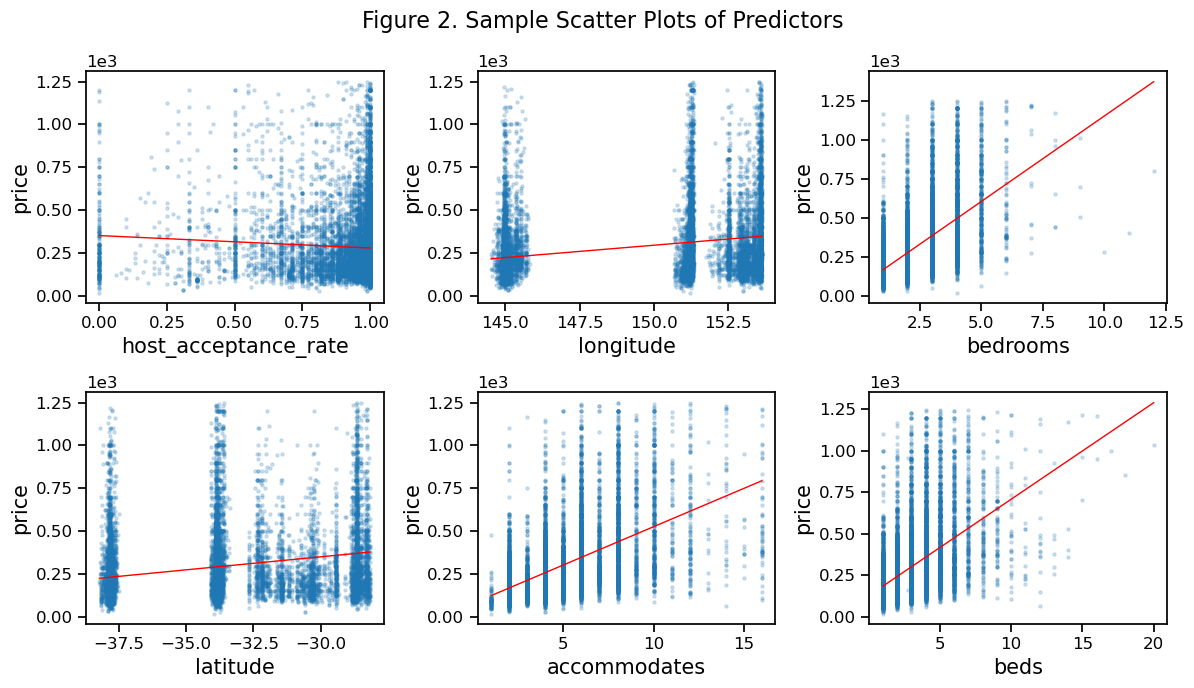

In [73]:
# 在重新整体看一下他们的分布情况
select_predictors = num_var[:6]

fig, axs = plt.subplots(2, 3, figsize=(12, 7))
for i in range(len(select_predictors)):
    ax = sns.regplot(x=select_predictors[i], y='price', ax=axs[i%2][(i//2)%3], data=data_train, ci=None, 
                scatter_kws={'s':5, 'alpha':0.2}, line_kws={'color':'red', 'linewidth':1})
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
fig.suptitle('Figure 2. Sample Scatter Plots of Predictors', fontsize=16)
plt.tight_layout()

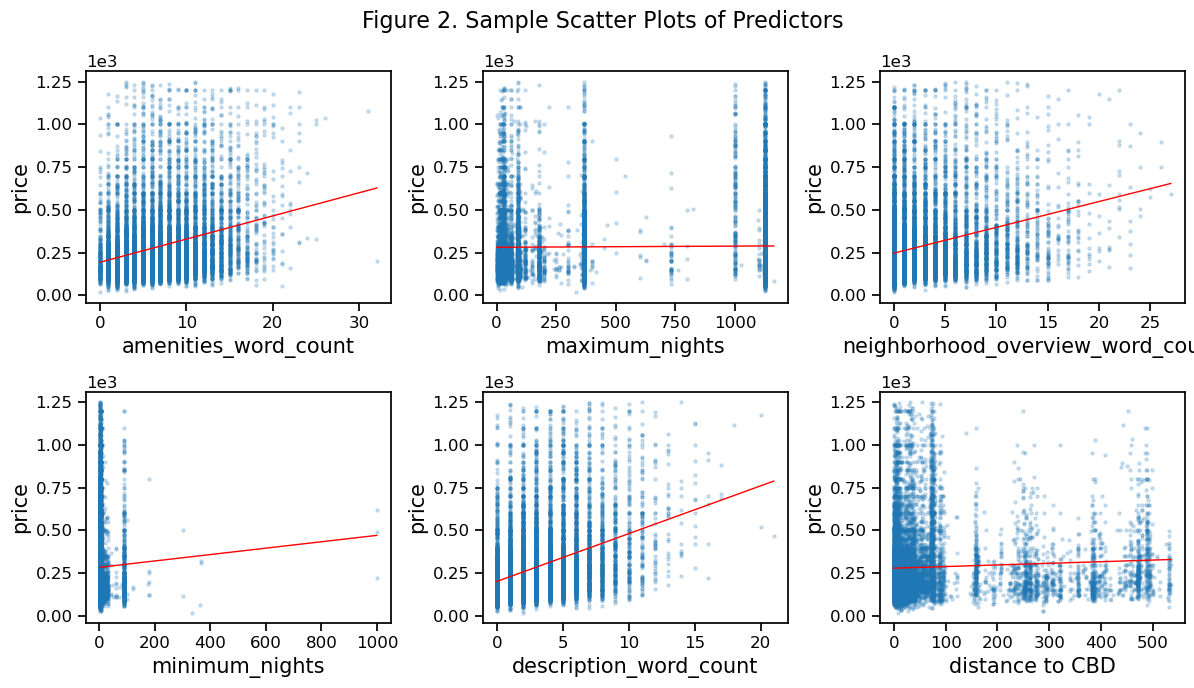

In [74]:
select_predictors = num_var[6:]

fig, axs = plt.subplots(2, 3, figsize=(12, 7))
for i in range(len(select_predictors)):
    ax = sns.regplot(x=select_predictors[i], y='price', ax=axs[i%2][(i//2)%3], data=data_train, ci=None, 
                scatter_kws={'s':5, 'alpha':0.2}, line_kws={'color':'red', 'linewidth':1})
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
fig.suptitle('Figure 2. Sample Scatter Plots of Predictors', fontsize=16)
plt.tight_layout()

In [75]:
#这里对neighborhood进行了feature engineering
mean_nei_price_train = data_train.groupby('neighbourhood')['price'].mean()

q3 = mean_nei_price_train.quantile(0.3)
q8 = mean_nei_price_train.quantile(0.8)

low = mean_nei_price_train[mean_nei_price_train <= q3].index
high = mean_nei_price_train[mean_nei_price_train>= q8].index
medium = mean_nei_price_train[(mean_nei_price_train > q3) & (mean_nei_price_train < q8)].index

In [76]:
data_train['nei_price_quality'] = ''
data_test['nei_price_quality'] = ''

data_train.loc[data_train['neighbourhood'].isin(low),'nei_price_qlty'] = 'low'
data_train.loc[data_train['neighbourhood'].isin(medium),'nei_price_qlty'] = 'medium'
data_train.loc[data_train['neighbourhood'].isin(high),'nei_price_qlty'] = 'high'

data_test.loc[data_test['neighbourhood'].isin(low),'nei_price_qlty'] = 'low'
data_test.loc[data_test['neighbourhood'].isin(medium),'nei_price_qlty'] = 'medium'
data_test.loc[data_test['neighbourhood'].isin(high),'nei_price_qlty'] = 'high'

C:\Users\Cayde Li\AppData\Local\Temp\ipykernel_20800\1253266707.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_train.loc[data_train['neighbourhood'].isin(low),'nei_price_qlty'] = 'low'
C:\Users\Cayde Li\AppData\Local\Temp\ipykernel_20800\1253266707.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_test.loc[data_test['neighbourhood'].isin(low),'nei_price_qlty'] = 'low'


In [77]:
#get dummy variables
dm_train = pd.get_dummies(data_train,drop_first = True,dtype = int)
dm_test = pd.get_dummies(data_test,drop_first = True, dtype = int)

In [78]:
#看和价格的相关性
dm_train.corr()['price'].sort_values(ascending = False)

price                                      1.000000
logprice                                   0.932796
bedrooms                                   0.615000
accommodates                               0.557825
beds                                       0.517012
property_type_Entire home                  0.418467
description_word_count                     0.366445
amenities_word_count                       0.275456
neighborhood_overview_word_count           0.273395
longitude                                  0.257643
latitude                                   0.256597
neighbourhood_BYRON SHIRE COUNCIL          0.217386
neighbourhood_Pittwater                    0.138144
property_type_Entire villa                 0.086379
neighbourhood_Manly                        0.073790
neighbourhood_TWEED SHIRE COUNCIL          0.072199
neighbourhood_Waverley                     0.063251
distance to CBD                            0.057506
property_type_Entire townhouse             0.048711
neighbourhoo

In [79]:
#看和log后的价格的相关性
corr_logprice = dm_train.corr()['logprice'].sort_values(ascending = False)
corr_logprice

logprice                                   1.000000
price                                      0.932796
bedrooms                                   0.633050
accommodates                               0.577379
beds                                       0.535111
property_type_Entire home                  0.423476
description_word_count                     0.379990
amenities_word_count                       0.290750
neighborhood_overview_word_count           0.284653
longitude                                  0.284338
latitude                                   0.274495
neighbourhood_BYRON SHIRE COUNCIL          0.203183
neighbourhood_Pittwater                    0.116860
neighbourhood_Waverley                     0.080582
property_type_Entire villa                 0.080292
distance to CBD                            0.079675
neighbourhood_Manly                        0.078828
neighbourhood_TWEED SHIRE COUNCIL          0.075968
property_type_Entire townhouse             0.072370
neighbourhoo

In [80]:
#取相关性比较大的变量，方便后面线性模型使用
best_para_index = corr_logprice.loc[(corr_logprice > 0.2)| (corr_logprice < -0.2)].index
best_para_logprice = dm_train[best_para_index]
best_para_index

Index(['logprice', 'price', 'bedrooms', 'accommodates', 'beds',
       'property_type_Entire home', 'description_word_count',
       'amenities_word_count', 'neighborhood_overview_word_count', 'longitude',
       'latitude', 'neighbourhood_BYRON SHIRE COUNCIL', 'number_of_reviews',
       'property_type_Entire rental unit', 'nei_price_qlty_low'],
      dtype='object')

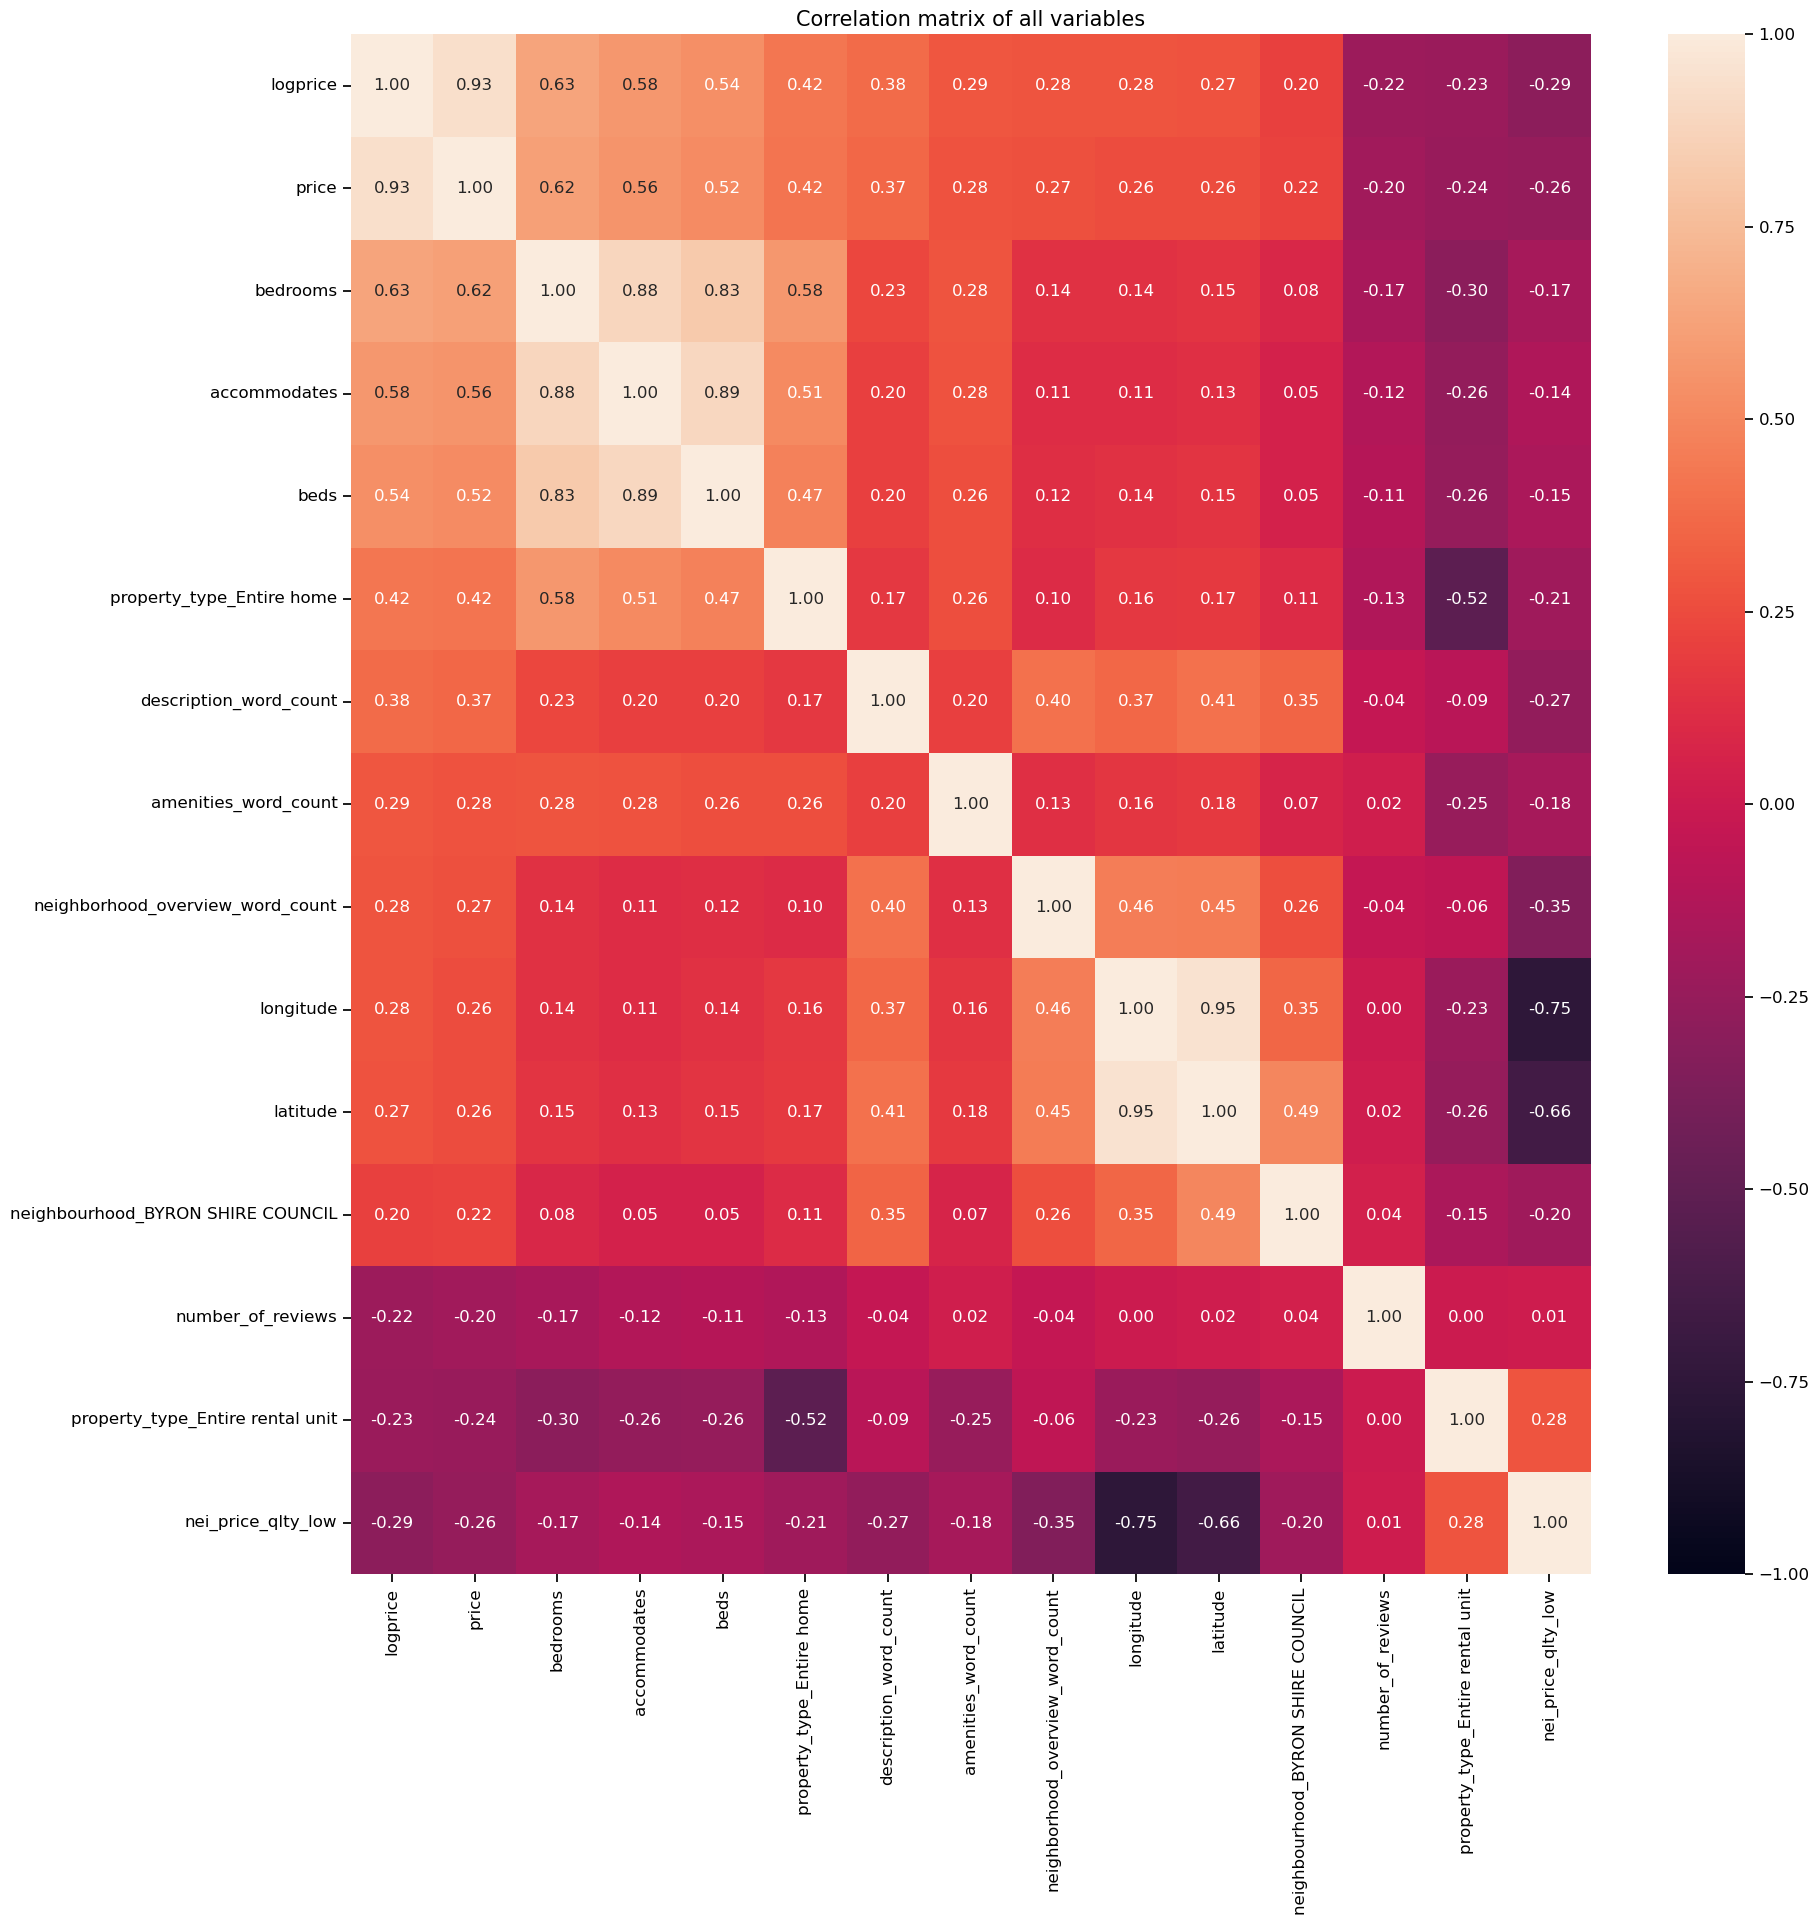

In [81]:
plt.figure(figsize = (20,20))
sns.heatmap(best_para_logprice.corr(),vmin = -1,vmax = 1, annot=True, fmt='.2f')
plt.title('Correlation matrix of all variables')
plt.show()

In [82]:
# 这里其实属于data processing，但是因为代码顺序问题只能放这里
X = dm_train.drop(columns=['price','logprice'])
y = dm_train['price']


# Split the data into a training set (80%) and a validation set (20%)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
linear_X_train=X_train[best_para_index[2:]]
linear_X_valid=X_valid[best_para_index[2:]]
linear_y_train=np.log(y_train)
linear_y_valid=np.log(y_valid)
X_test = dm_test
linear_X_test = dm_test[best_para_index[2:]].copy()


In [84]:
#将latitude变为正值，因为南纬是负的
X_train['latitude'] = -X_train['latitude']
X_valid['latitude'] = -X_valid['latitude']
linear_X_train['latitude'] = -linear_X_train['latitude']
linear_X_valid['latitude'] = -linear_X_valid['latitude']
X_test['latitude'] = -X_test['latitude']
linear_X_test['latitude'] = -linear_X_test['latitude']

C:\Users\Cayde Li\AppData\Local\Temp\ipykernel_20800\3201650984.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linear_X_train['latitude'] = -linear_X_train['latitude']
C:\Users\Cayde Li\AppData\Local\Temp\ipykernel_20800\3201650984.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linear_X_valid['latitude'] = -linear_X_valid['latitude']


interaction term: bedrooms * accommodates, bedrooms * beds, bedrooms * property_type_Entire home, bedrooms * property_type_Entire rental unit, beds * accommodates, accommodates * property_type_Entire home, accommodates * property_type_Entire rental unit, neighbourhood_BYRON SHIRE COUNCIL * longitude, neighbourhood_BYRON SHIRE COUNCIL * latitude, latitude * longitude

In [85]:
#检查skewness 和 kurtosis
descriptives  = X_train.describe()
descriptives.loc['Skewness',:] = X_train.skew()
descriptives.loc['kurt',:] = X_train.kurt()
descriptives

host_acceptance_rate     latitude    longitude  accommodates  \
count              9993.000000  9993.000000  9993.000000   9993.000000   
mean                  0.917319    34.270666   149.298494      4.602622   
std                   0.175243     3.402520     3.599370      2.513833   
min                   0.000000    28.165120   144.552640      1.000000   
25%                   0.930000    31.971600   144.990550      2.000000   
50%                   0.990000    33.888398   151.191920      4.000000   
75%                   1.000000    37.813470   152.541920      6.000000   
max                   1.000000    38.219124   153.636110     16.000000   
Skewness             -3.371074    -0.393859    -0.243742      1.235791   
kurt                 12.463437    -1.164931    -1.740309      2.134666   

             bedrooms         beds  minimum_nights  maximum_nights  \
count     9993.000000  9993.000000     9993.000000     9993.000000   
mean         2.091864     2.721652        6.433203      578.543681   
std          1.124980     1.778882       24.853856      484.694397   
min          1.000000     1.000000        1.000000        1.000000   
25%          1.000000     1.000000        2.000000       84.000000   
50%          2.000000     2.000000        2.000000      365.000000   
75%          3.000000     4.000000        3.000000     1125.000000   
max         10.000000    17.000000      999.000000     1162.000000   
Skewness     1.101800     1.669451       21.831691        0.121045   
kurt         1.468044     4.728663      784.560213       -1.806097   

          number_of_reviews  description_word_count  ...  \
count           9993.000000             9993.000000  ...   
mean              56.313620                2.998099  ...   
std               81.870189                2.648605  ...   
min                1.000000                0.000000  ...   
25%                7.000000                1.000000  ...   
50%               25.000000                2.000000  ...   
75%               72.000000                4.000000  ...   
max             1013.000000               21.000000  ...   
Skewness           3.285195                1.300792  ...   
kurt              17.035984                2.192598  ...   

          property_type_Entire serviced apartment  \
count                                 9993.000000   
mean                                     0.021415   
std                                      0.144770   
min                                      0.000000   
25%                                      0.000000   
50%                                      0.000000   
75%                                      0.000000   
max                                      1.000000   
Skewness                                 6.612963   
kurt                                    41.739627   

          property_type_Entire townhouse  property_type_Entire villa  \
count                        9993.000000                 9993.000000   
mean                            0.034824                    0.010007   
std                             0.183344                    0.099538   
min                             0.000000                    0.000000   
25%                             0.000000                    0.000000   
50%                             0.000000                    0.000000   
75%                             0.000000                    0.000000   
max                             1.000000                    1.000000   
Skewness                        5.075365                    9.847295   
kurt                           23.764087                   94.988229   

          property_type_Farm stay  property_type_others  \
count                 9993.000000           9993.000000   
mean                     0.011508              0.079956   
std                      0.106662              0.271239   
min                      0.000000              0.000000   
25%                      0.000000              0.000000   
50%                      0.00000

In [86]:
X_test.shape

(2500, 73)

In [87]:
#take log1p to all numerical variables with bad skewness
num_var = ['bedrooms','accommodates','beds','longitude','latitude','description_word_count','neighborhood_overview_word_count'] #,'number_of_reviews'
bad_num_var = [x for x in num_var if np.abs(descriptives.loc['Skewness',x]) >= 0.05]

linear_X_train_log = linear_X_train.copy()
linear_X_train_log[num_var] = np.log1p(linear_X_train_log[bad_num_var])

linear_X_valid_log = linear_X_valid.copy()
linear_X_valid_log[num_var] = np.log1p(linear_X_valid_log[bad_num_var])

linear_X_test_log = linear_X_test.copy()
linear_X_test_log[num_var] = np.log1p(linear_X_test_log[bad_num_var])

In [88]:
#standardise all numerical variables
from sklearn.preprocessing import StandardScaler

linear_X_train_log_std = linear_X_train_log.copy()
linear_X_valid_log_std = linear_X_valid_log.copy()
linear_X_test_log_std = linear_X_test_log.copy()

stdScaler = StandardScaler().fit(linear_X_train_log.loc[:,num_var])

linear_X_train_log_std.loc[:,num_var] = stdScaler.transform(linear_X_train_log_std.loc[:,num_var])
linear_X_valid_log_std.loc[:,num_var] = stdScaler.transform(linear_X_valid_log_std.loc[:,num_var])
linear_X_test_log_std.loc[:,num_var] = stdScaler.transform(linear_X_test_log_std.loc[:,num_var])

In [89]:
#做了一些interaction
linear_X_train['number_of_reviews * nei_price_qlty_low'] = linear_X_train['number_of_reviews'] * linear_X_train['nei_price_qlty_low']
linear_X_valid['number_of_reviews * nei_price_qlty_low'] = linear_X_valid['number_of_reviews'] * linear_X_valid['nei_price_qlty_low']
linear_X_test['number_of_reviews * nei_price_qlty_low'] = linear_X_test['number_of_reviews'] * linear_X_test['nei_price_qlty_low']
linear_X_train['bedrooms * nei_price_qlty_low'] = linear_X_train['bedrooms'] * linear_X_train['nei_price_qlty_low']
linear_X_valid['bedrooms * nei_price_qlty_low'] = linear_X_valid['bedrooms'] * linear_X_valid['nei_price_qlty_low']
linear_X_test['bedrooms * nei_price_qlty_low'] = linear_X_test['bedrooms'] * linear_X_test['nei_price_qlty_low']

C:\Users\Cayde Li\AppData\Local\Temp\ipykernel_20800\512677962.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linear_X_train['number_of_reviews * nei_price_qlty_low'] = linear_X_train['number_of_reviews'] * linear_X_train['nei_price_qlty_low']
C:\Users\Cayde Li\AppData\Local\Temp\ipykernel_20800\512677962.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linear_X_valid['number_of_reviews * nei_price_qlty_low'] = linear_X_valid['number_of_reviews'] * linear_X_valid['nei_price_qlty_low']
C:\Users\Cayde

In [90]:
linear_X_train_log_std['number_of_reviews * nei_price_qlty_low'] = linear_X_train_log_std['number_of_reviews'] * linear_X_train_log_std['nei_price_qlty_low']
linear_X_valid_log_std['number_of_reviews * nei_price_qlty_low'] = linear_X_valid_log_std['number_of_reviews'] * linear_X_valid_log_std['nei_price_qlty_low']
linear_X_test_log_std['number_of_reviews * nei_price_qlty_low'] = linear_X_test_log_std['number_of_reviews'] * linear_X_test_log_std['nei_price_qlty_low']
linear_X_train_log_std['bedrooms * nei_price_qlty_low'] = linear_X_train_log_std['bedrooms'] * linear_X_train_log_std['nei_price_qlty_low']
linear_X_valid_log_std['bedrooms * nei_price_qlty_low'] = linear_X_valid_log_std['bedrooms'] * linear_X_valid_log_std['nei_price_qlty_low']
linear_X_test_log_std['bedrooms * nei_price_qlty_low'] = linear_X_test_log_std['bedrooms'] * linear_X_test_log_std['nei_price_qlty_low']

## <font color = '#e64626'><a id='methodology'>4. Methodology</a></font>

### <font color = '#e64626'><a id='model_1'>4.1. Model_1: Elastic Net</a></font>

In [91]:
from sklearn.linear_model import ElasticNetCV, ElasticNet

elastic_net = ElasticNetCV(l1_ratio=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99,1], cv=5)
elastic=elastic_net.fit(linear_X_train_log_std, linear_y_train)

In [92]:
#这个ratio因为直接是1.0，所以也可以说它是一个lasso
elastic.l1_ratio_

1.0

In [93]:
model_5=elastic

In [94]:
# 拿验证集验证
forecast_5 = model_5.predict(linear_X_valid_log_std)
mse_5=mse(np.exp(linear_y_valid),np.exp(forecast_5))
rmse_5=mse_5**0.5
rmse_5

154.77677245932352

Text(0.5, 1.0, 'Elastic net')

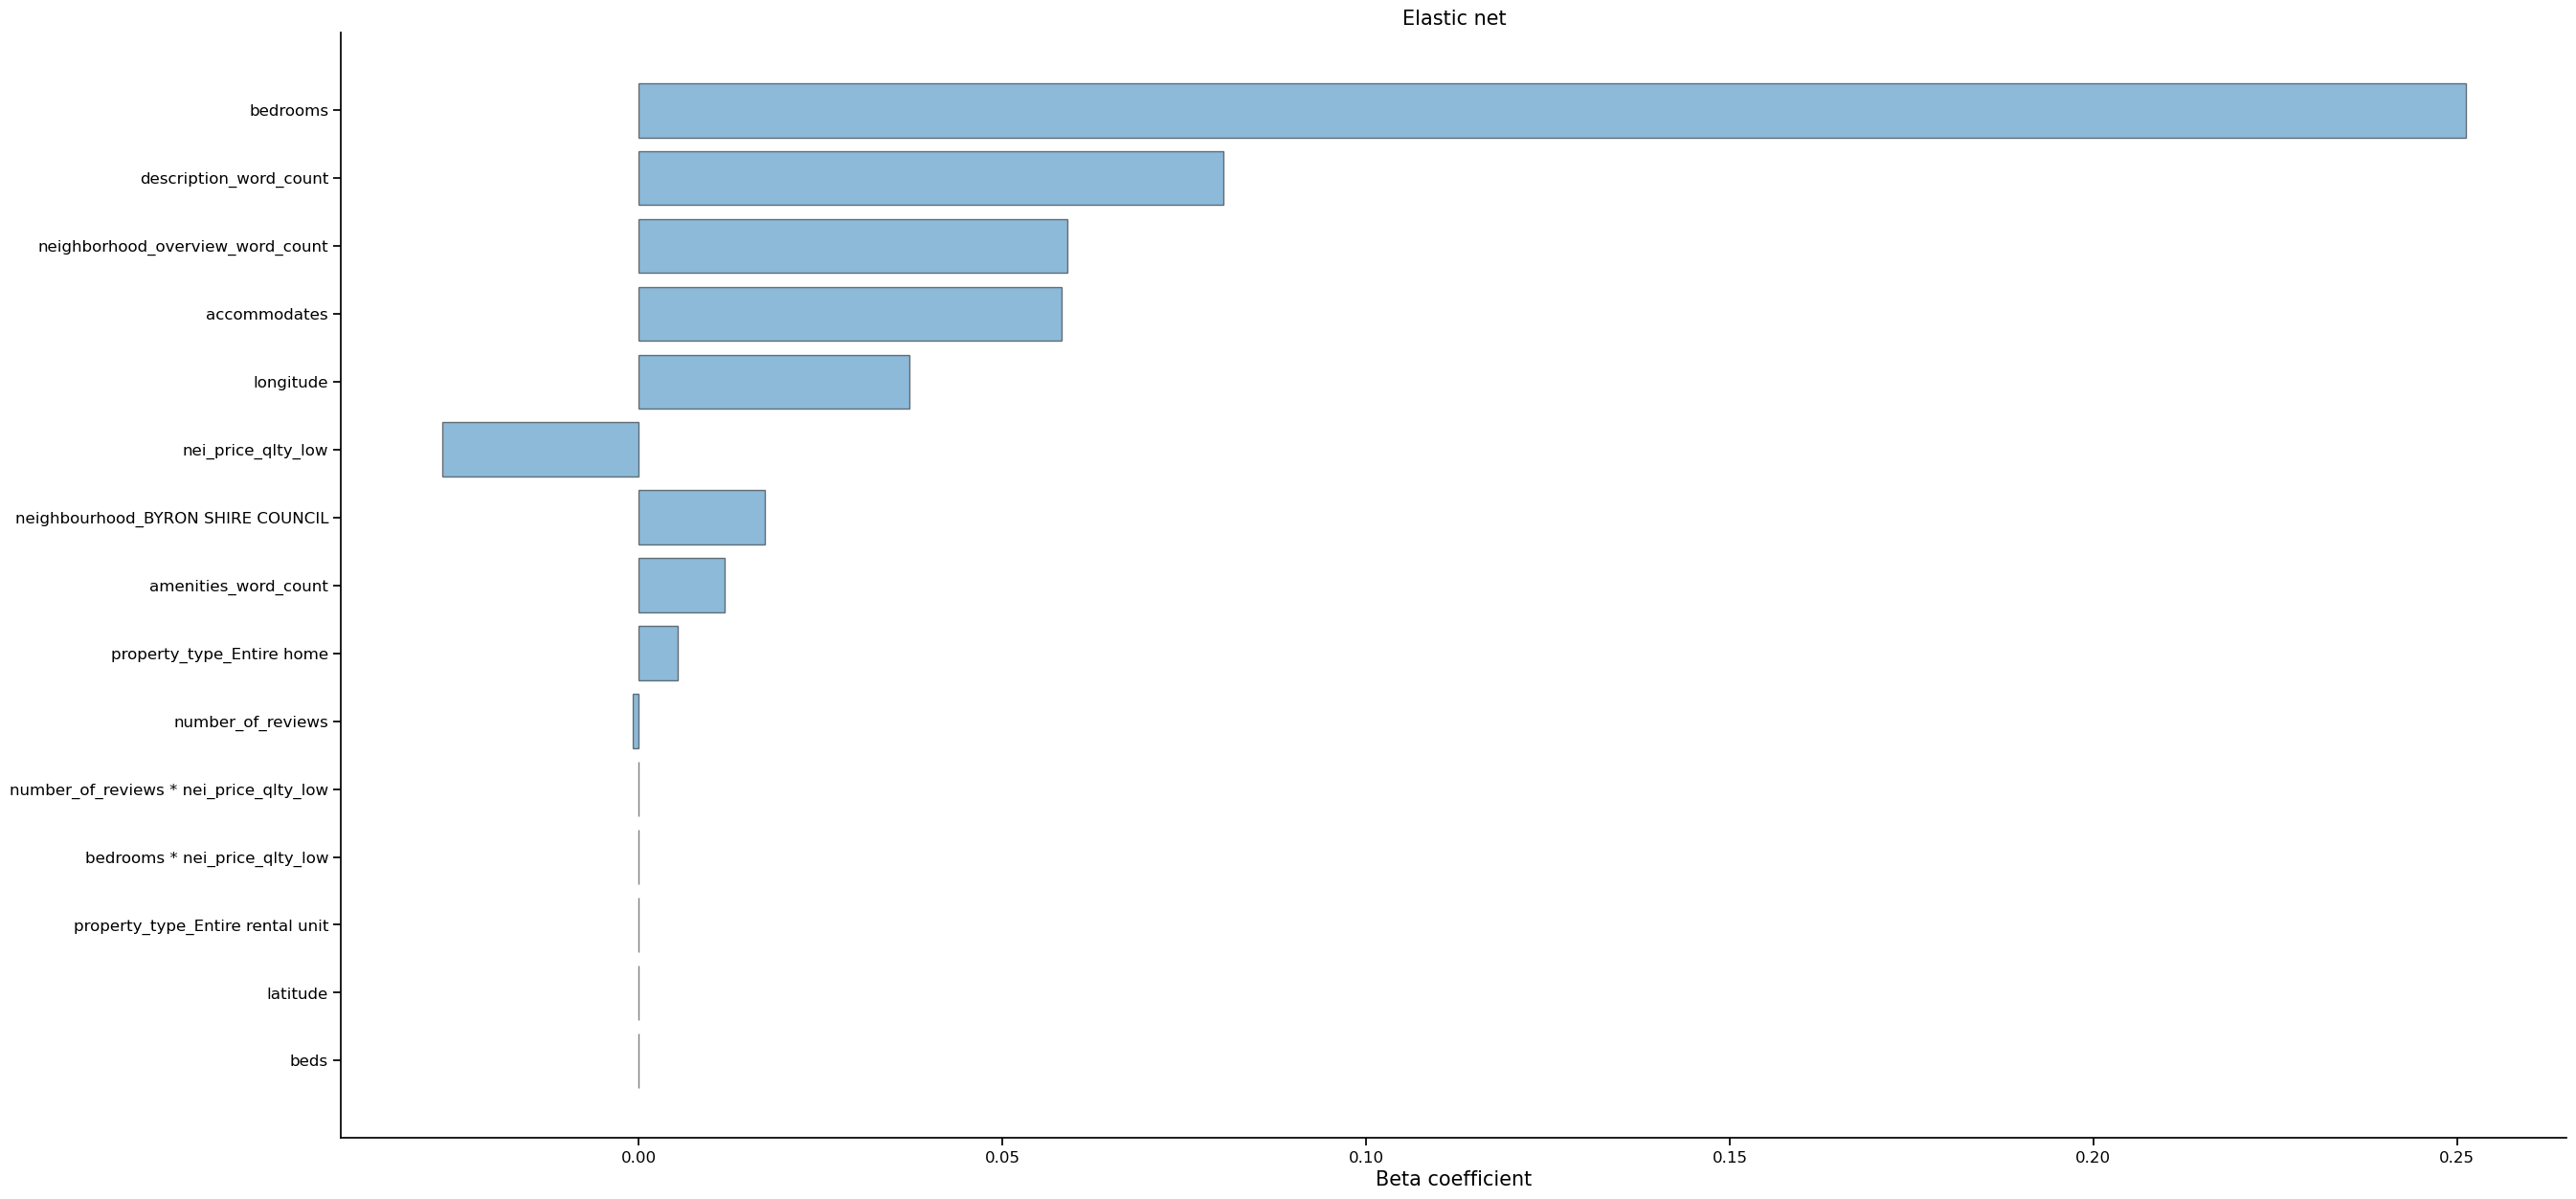

In [95]:
# 看各变量的重要程度
betas = elastic_net.coef_
predictors = list(linear_X_train_log_std.columns.values[:])
indicies = np.argsort(np.abs(betas))[-20:]
top_predictors = np.array(predictors)[indicies]
top_betas = betas[indicies]

plt.figure(figsize = (30, 15))
plt.barh(top_predictors, top_betas, alpha=0.5, edgecolor='black')
sns.despine()
plt.xlabel('Beta coefficient')
plt.title('Elastic net')

In [94]:
# 出预测结果
result = elastic_net.predict(linear_X_test_log_std.values)

result = np.exp(result)

id_col = np.arange(2500).reshape(-1, 1)
y_pred = result.reshape(-1, 1)

data = np.hstack((id_col, y_pred))

elastic_submission = pd.DataFrame(data, columns=['id', 'price'])
elastic_submission['id'] = elastic_submission['id'].astype('int')

elastic_submission.to_csv('elastic_submission.csv', index=False)

C:\Users\Cayde Li\anaconda3\envs\6810\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(


### <font color = '#e64626'><a id='model_2'>4.2. Model_2: Decision Tree</a></font> 

In [97]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

In [98]:
tree = DecisionTreeRegressor(criterion= 'squared_error', min_samples_leaf=5)

path = tree.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [99]:
#这段code很吃性能，不要随便跑
model_tree = DecisionTreeRegressor(criterion='squared_error',min_samples_leaf= 5,random_state=1)
tuning_parameters = { 'ccp_alpha' :ccp_alphas}

tree_cv = GridSearchCV(model_tree, tuning_parameters, cv = 5, return_train_score=False, n_jobs= -1)
tree_cv.fit(X_train,y_train)

model_6 = tree_cv.best_estimator_

In [100]:
# 拿验证集验证
forecast_6 = model_6.predict(X_valid)
mse_6=mse(y_valid,forecast_6)
rmse_6=mse_6**0.5
rmse_6

144.96174518724555

In [101]:
# 出预测结果
result = tree_cv.predict(X_test.values)

id_col = np.arange(2500).reshape(-1, 1)
y_pred = result.reshape(-1, 1)

data = np.hstack((id_col, y_pred))

tree_submission = pd.DataFrame(data, columns=['id', 'price'])
tree_submission['id'] = tree_submission['id'].astype('int')

tree_submission.to_csv('tree_submission.csv', index=False)

C:\Users\Cayde Li\anaconda3\envs\6810\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


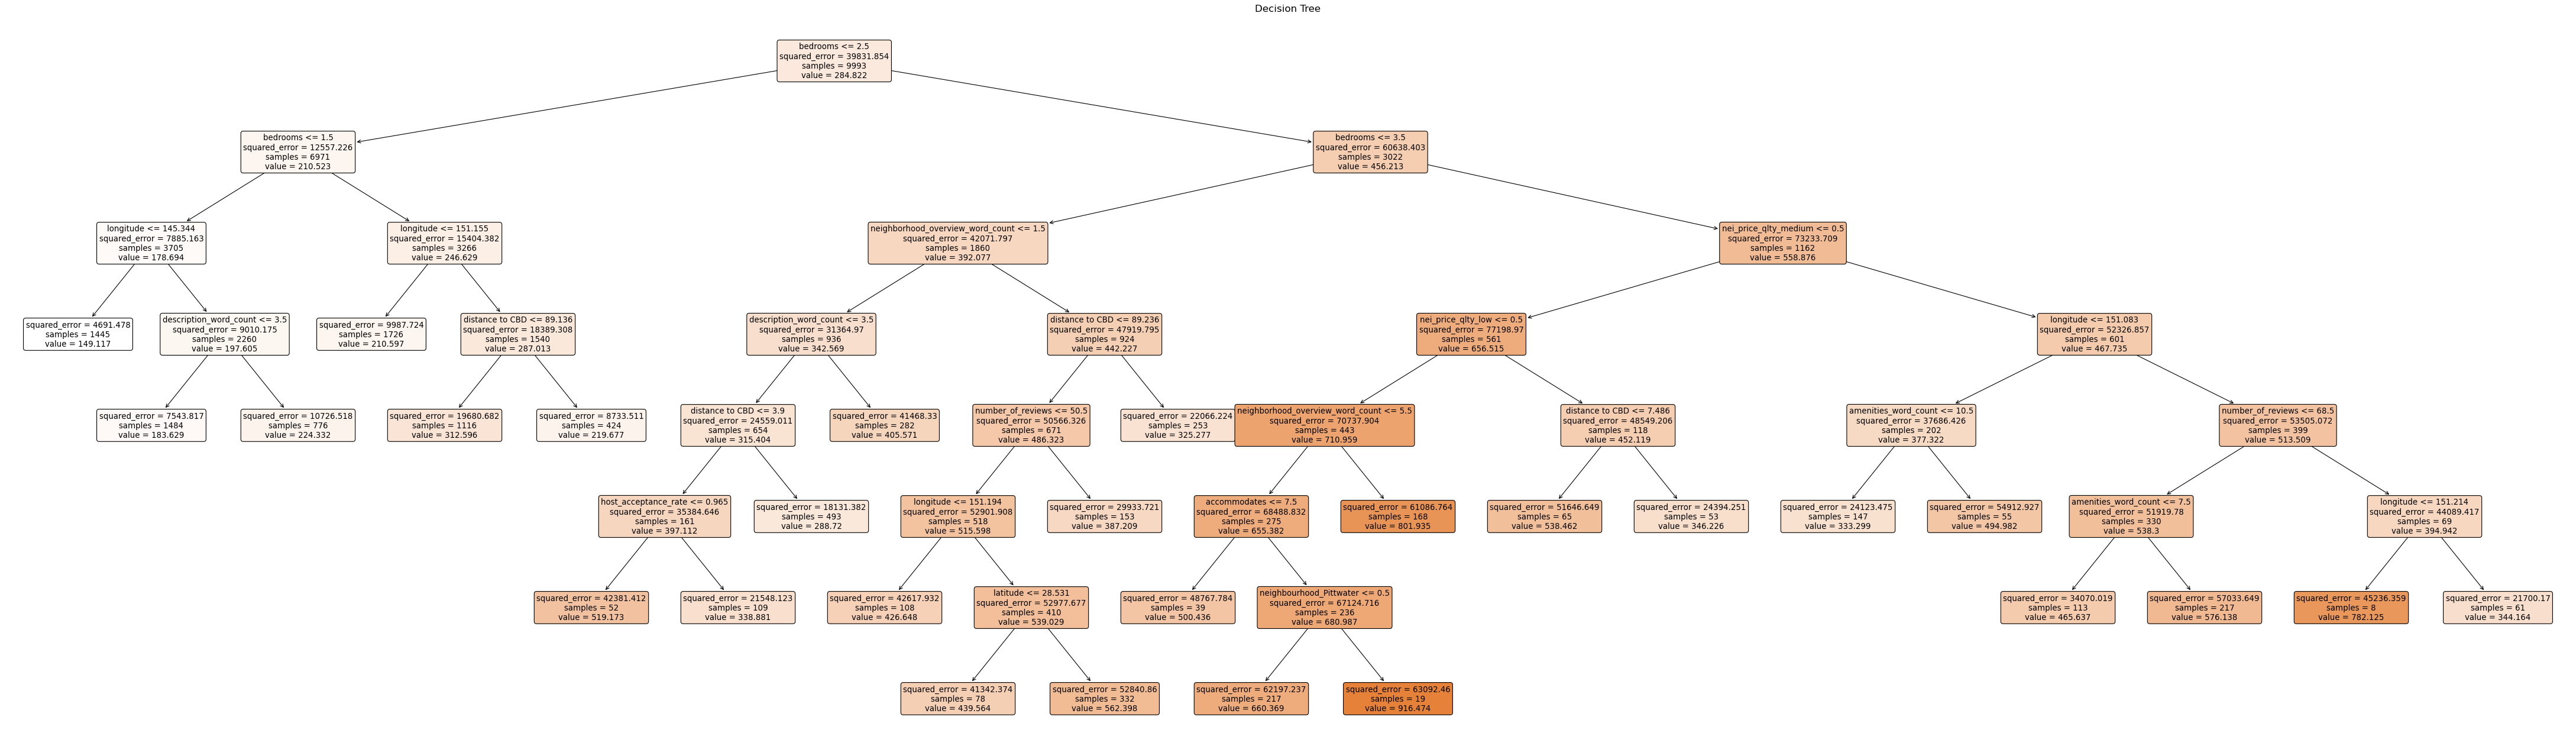

In [104]:
plt.figure(figsize=(70,20), dpi = 80)
fig=plot_tree(model_6, filled = True, rounded = True, feature_names = X_train.columns.tolist(), fontsize = 12)
plt.title('Decision Tree')
plt.savefig('decision_tree.png',dpi = 300)

### <font color = '#e64626'><a id='model_3'>4.3. Model_3: Xgboost</a></font> 

In [134]:
import xgboost as xgb

In [135]:
%%time
#大概跑一个小时
model=xgb.XGBRegressor(objective='reg:squarederror',reg_lambda=0.5)
tuning_parameters = {
    'learning_rate': [0.01,0.03,0.05, 0.1],
    'n_estimators': [2300,2400,2500,2600,2700,2800,2900,3000,3100,3200],
    'max_depth': [4,5,6,7,8,9,10],
    'subsample': [0.5,0.6,0.7,0.8,0.9,1.0]
}
xgbo=RandomizedSearchCV(model,tuning_parameters, n_iter=32,cv=5,random_state=87,n_jobs=-1)
xgbo=xgbo.fit(X_train, y_train)
xgbo.best_params_

CPU times: user 3min 52s, sys: 21.7 s, total: 4min 13s
Wall time: 55min 5s


{'subsample': 0.6, 'n_estimators': 3000, 'max_depth': 7, 'learning_rate': 0.01}

In [136]:
model_2=xgbo.best_estimator_

In [137]:
forecast_2 = model_2.predict(X_valid)
mse_2=mse(y_valid,forecast_2)
rmse_2=mse_2**0.5
rmse_2

123.61154464186507

Text(0.5, 1.0, 'Variable Importance of Xgboost')

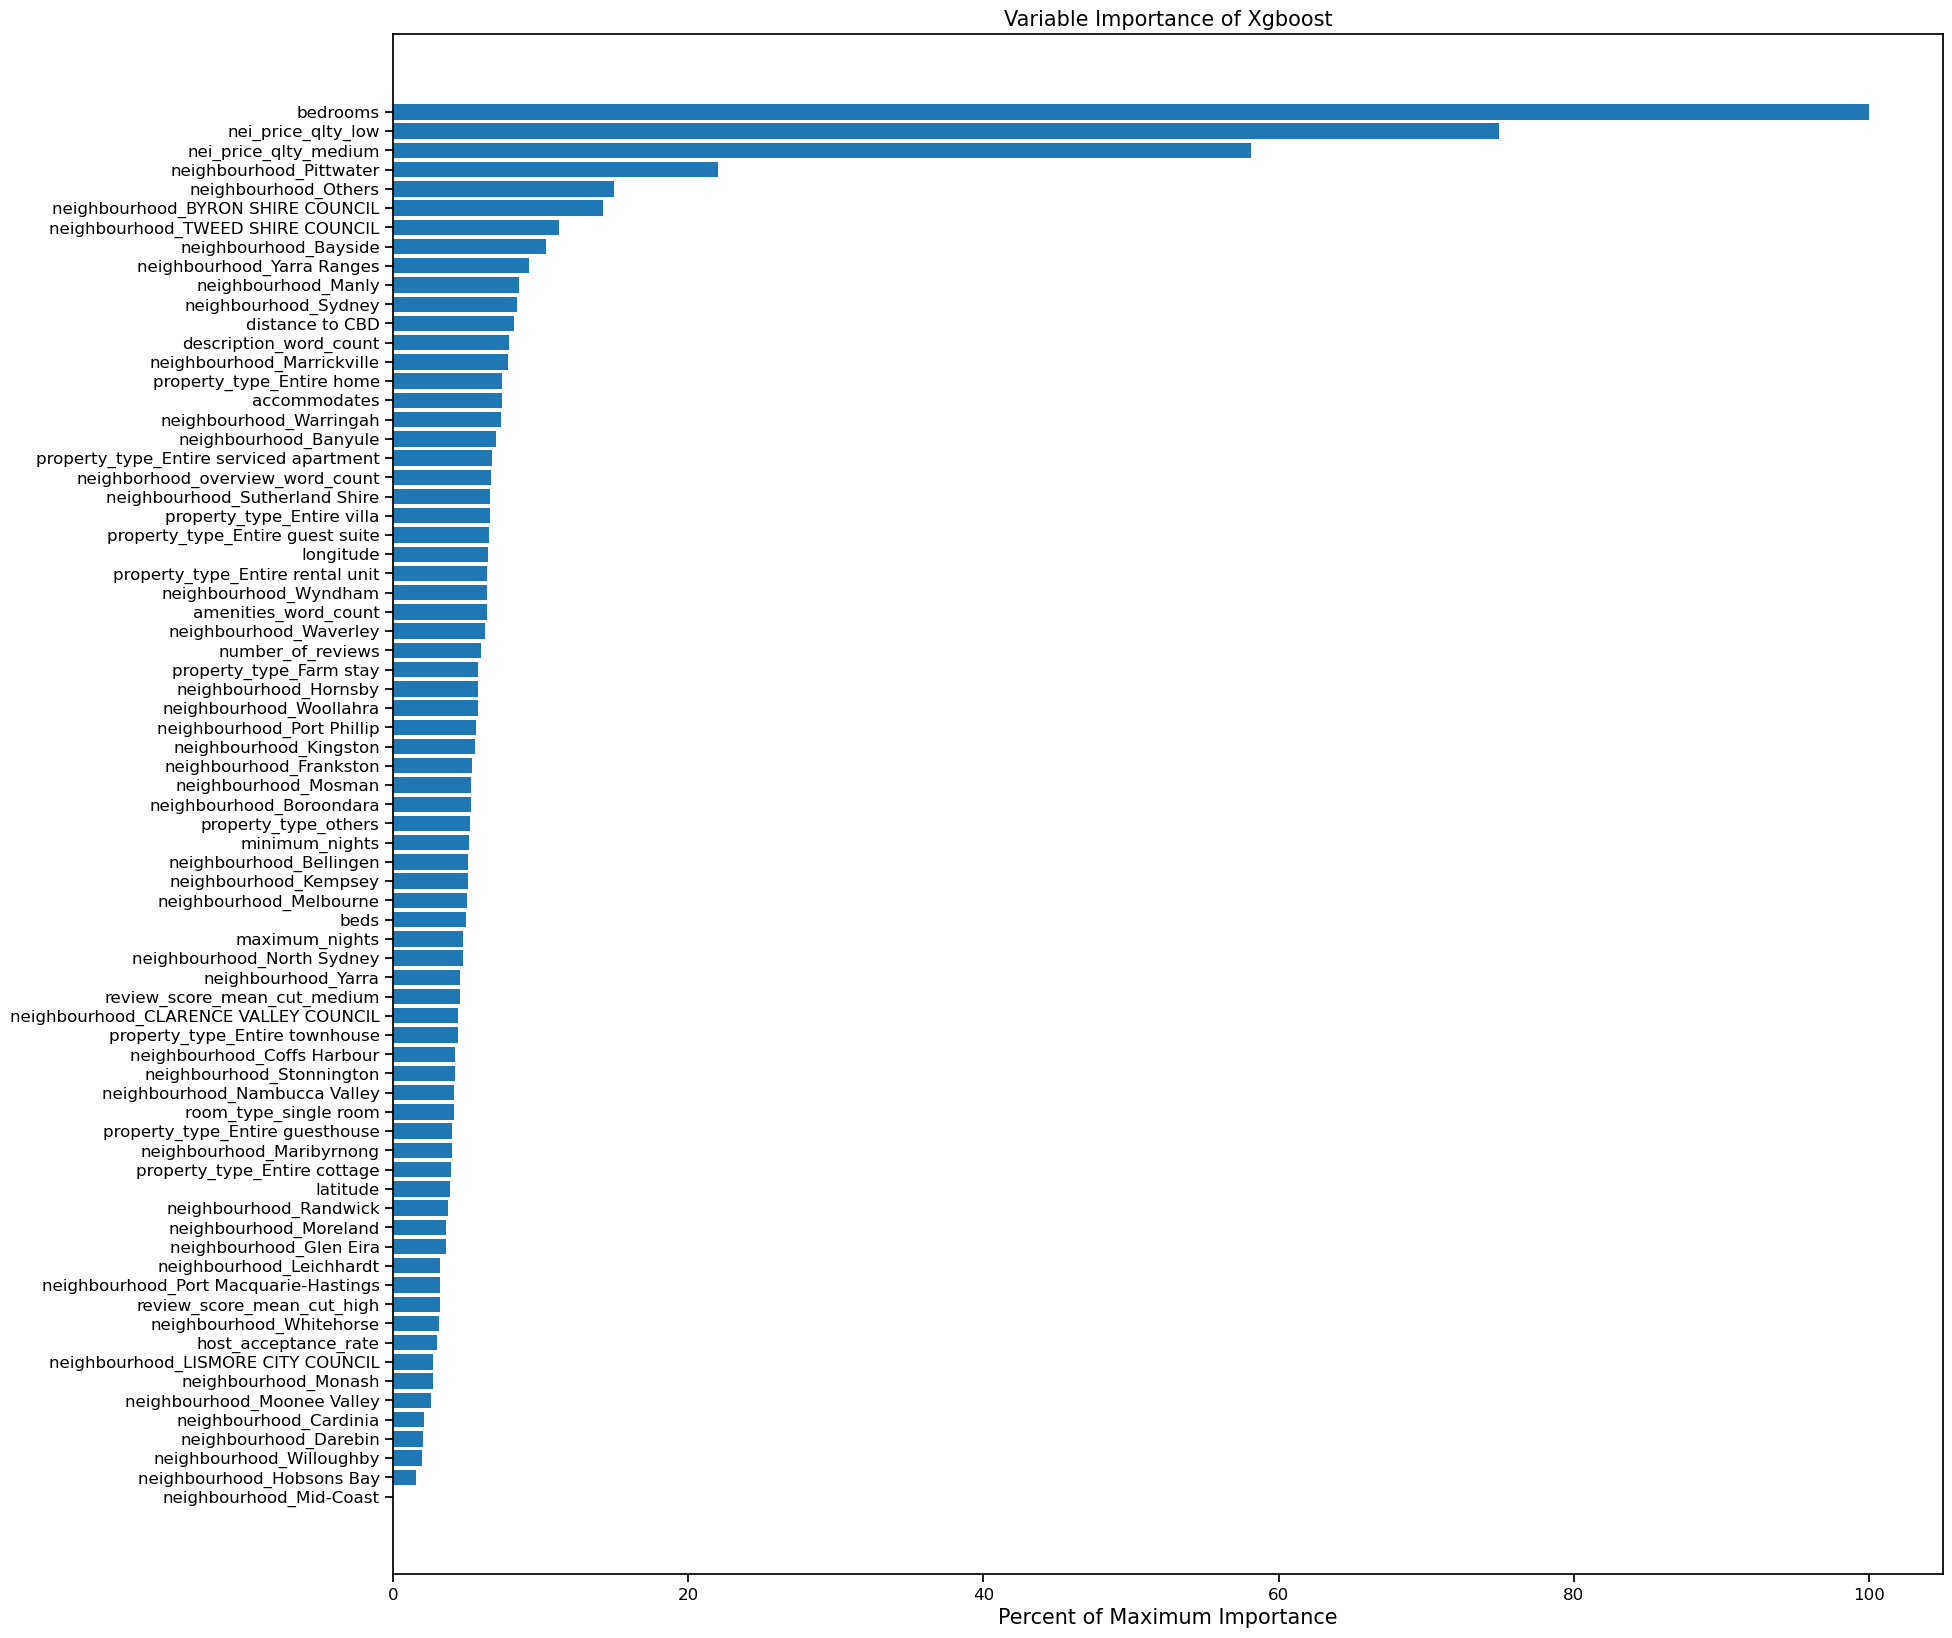

In [139]:
# 查看变量重要程度
plt.figure(figsize=(20,20))
importance=100*(model_2.feature_importances_/np.max(model_2.feature_importances_))
feature_importance=pd.Series(importance,index=X_train.columns).sort_values(ascending=True)
plt.barh(np.arange(len(X_train.columns)),feature_importance)
plt.yticks(np.arange(len(X_train.columns)),feature_importance.index)
plt.xlabel('Percent of Maximum Importance')
plt.title('Variable Importance of Xgboost')

In [ ]:
result = model_2.predict(X_test.values)


id_col = np.arange(2500).reshape(-1, 1)
y_pred = result.reshape(-1, 1)

data = np.hstack((id_col, y_pred))

xgb_submission = pd.DataFrame(data, columns=['id', 'price'])
xgb_submission['id'] = xgb_submission['id'].astype('int')

xgb_submission.to_csv('xgb_submission.csv', index=False)

## <font color = '#e64626'><a id='appendix'>5. Appendix-Other Models We Tried</a></font>

### Gradiant Boosting

In [ ]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
# 大概要跑40分钟
model = GradientBoostingRegressor()

tuning_parameters = {
    'learning_rate': [0.01],
    'n_estimators': [2300,2400,2500,2600,2700,2800,2900,3000,3100,3200],
    'max_depth': [4,5,6,7,8,9,10],
    'subsample': [0.4,0.5,0.6,0.7,0.8,0.9,1.0]
}

gb=RandomizedSearchCV(model,param_distributions=tuning_parameters, n_iter=32,cv=5,random_state=87,n_jobs=-1)
gb=gb.fit(X_train, y_train)
gb.best_params_


In [ ]:
model_1=gb.best_estimator_

In [ ]:
forecast_1 = model_1.predict(X_valid)
mse_1=mse(y_valid,forecast_1)
rmse_1=mse_1**0.5
rmse_1

In [ ]:
result = model_1.predict(X_test.values)


id_col = np.arange(2500).reshape(-1, 1)
y_pred = result.reshape(-1, 1)

data = np.hstack((id_col, y_pred))

gb_submission = pd.DataFrame(data, columns=['id', 'price'])
gb_submission['id'] = gb_submission['id'].astype('int')

gb_submission.to_csv('gb_submission.csv', index=False)

### LightGBM

In [ ]:
import lightgbm as lgb

In [ ]:
%%time
#跑五分钟
model=lgb.LGBMRegressor(objective='regression')
tuning_parameters = {
    'learning_rate': [0.01],
    'n_estimators': [3000,4000,4500,5000,5500,6000,6500,6600,6700,6800,6900,7000],
    'num_leaves': list(np.arange(2,64)),
    'subsample': [0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99,1.0]}

lgbm = RandomizedSearchCV(model,tuning_parameters, n_iter=40,cv=5,random_state=87,n_jobs=-1)
lgbm=lgbm.fit(X_train, y_train)
lgbm.best_params_

In [ ]:
model_3=lgbm.best_estimator_

In [ ]:
forecast_3 = model_3.predict(X_valid)
mse_3=mse(y_valid,forecast_3)
rmse_3=mse_3**0.5
rmse_3

In [ ]:
result = model_3.predict(X_test.values)


id_col = np.arange(2500).reshape(-1, 1)
y_pred = result.reshape(-1, 1)

data = np.hstack((id_col, y_pred))

lgbm_submission = pd.DataFrame(data, columns=['id', 'price'])
lgbm_submission['id'] = lgbm_submission['id'].astype('int')

lgbm_submission.to_csv('lgbm_submission.csv', index=False)

### Stacked Model

In [ ]:
from mlxtend.regressor import StackingCVRegressor

In [ ]:
%%time
#大概跑10分钟
models=[model_2,model_5]
stack=StackingCVRegressor(models,meta_regressor=LinearRegression(),cv=5)
model_4=stack.fit(X_train.values, y_train.values)


In [ ]:
forecast_4 = model_4.predict(X_valid)
mse_4=mse(y_valid,forecast_4)
rmse_4=mse_4**0.5
rmse_4

In [ ]:
result = model_4.predict(X_test.values)


id_col = np.arange(2500).reshape(-1, 1)
y_pred = result.reshape(-1, 1)

data = np.hstack((id_col, y_pred))

stack_submission = pd.DataFrame(data, columns=['id', 'price'])
stack_submission['id'] = stack_submission['id'].astype('int')

stack_submission.to_csv('stack_submission.csv', index=False)